In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch 
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas  as pd
import random


from sklearn.cluster import KMeans
from tqdm import tqdm_notebook as tqdm

In [3]:
def make_data(n):
    _data = []
    _true = []
    for _ in range(n):
        i = 10*(np.random.rand()-0.5)
        x = np.linspace(i,i+6,200)
        x1 = np.sin(4*x)+np.random.rand(200)*0.3
        x2 = .3*(x**2)+np.random.rand(200)*0.3
        x3 = np.cos(5*x)+np.random.rand(200)*0.3
        true = x1+x2+x3
        x = np.vstack((x1,x2, x3))
        _data.append(x.tolist())
        _true.append(true)
    _data = torch.FloatTensor(_data)
    _true = torch.FloatTensor(_true)
    return _data, _true

In [17]:
class Autoencorder_1d(nn.Module):

    def __init__(self, input_size, dim_num):
        super(Autoencorder_1d, self).__init__()
        
        size_1 = input_size
        size_2 = 200
        size_3 = 400
        
        
        self.encorder = nn.Sequential(
            nn.Conv1d(size_1, size_2, 7),
            nn.GELU(),
            nn.Conv1d(size_2, size_3, 7)
        )
        
        self.lin = nn.Linear(size_3, dim_num)
        
        self.avgpool1d = nn.AdaptiveAvgPool1d(1)
        
        self.decorder = nn.Sequential(
            nn.Linear(dim_num, 2*dim_num),
            nn.GELU(),
            nn.Linear(2*dim_num, 4*dim_num),
            nn.GELU(),
            nn.Linear(4*dim_num, 200)
        ) 

    def forward(self, x):
        #_in = x.size()[1]
        x = self.encorder(x)
        x = self.avgpool1d(x)
        x = torch.flatten(x, 1)
        #print(x.size())
        x1 = self.lin(x)
        x = self.decorder(x1)

        return x1, x

In [18]:
model = Autoencorder_1d(3, 2)

In [19]:
data, true = make_data(n=1000)
data.size(), true.size()

(torch.Size([1000, 3, 200]), torch.Size([1000, 200]))

In [20]:
out1, out2 = model(data)
out1.size(), out2.size()

(torch.Size([1000, 2]), torch.Size([1000, 200]))

In [21]:
data.size()

torch.Size([1000, 3, 200])

In [22]:
model = Autoencorder_1d(3, 2)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [23]:
train_data = data[:800, :, :].to(device)
val_data = data[800:, : , :].to(device)
train_true = true[:800,:].to(device)
val_true = true[800:,:].to(device)

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

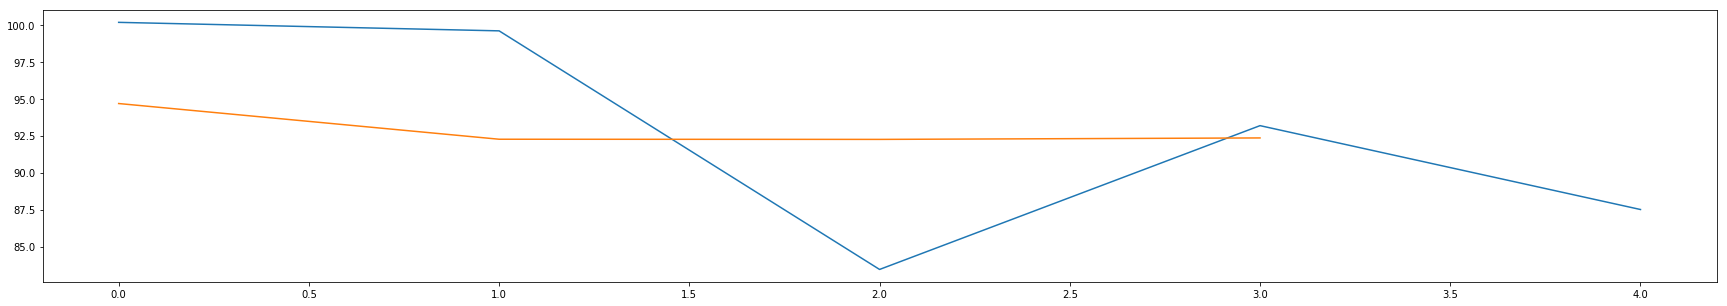

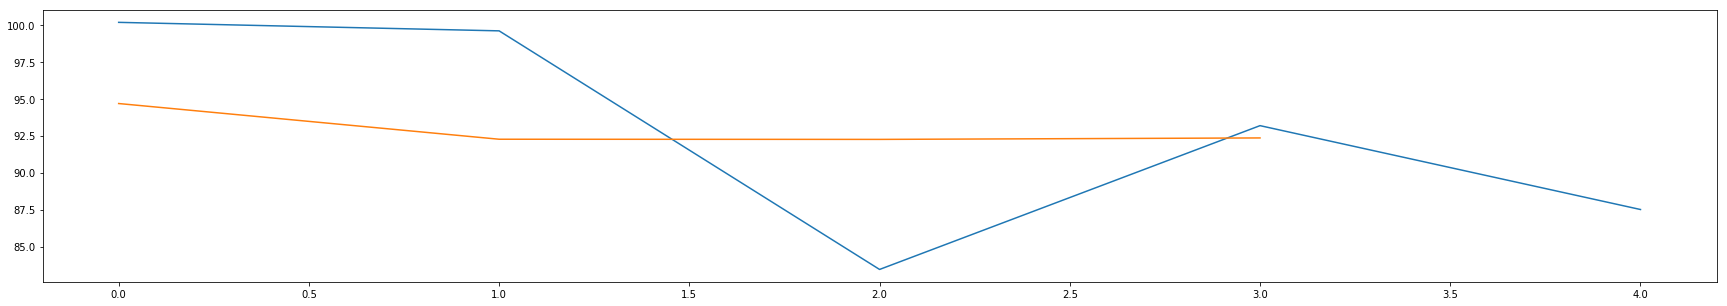

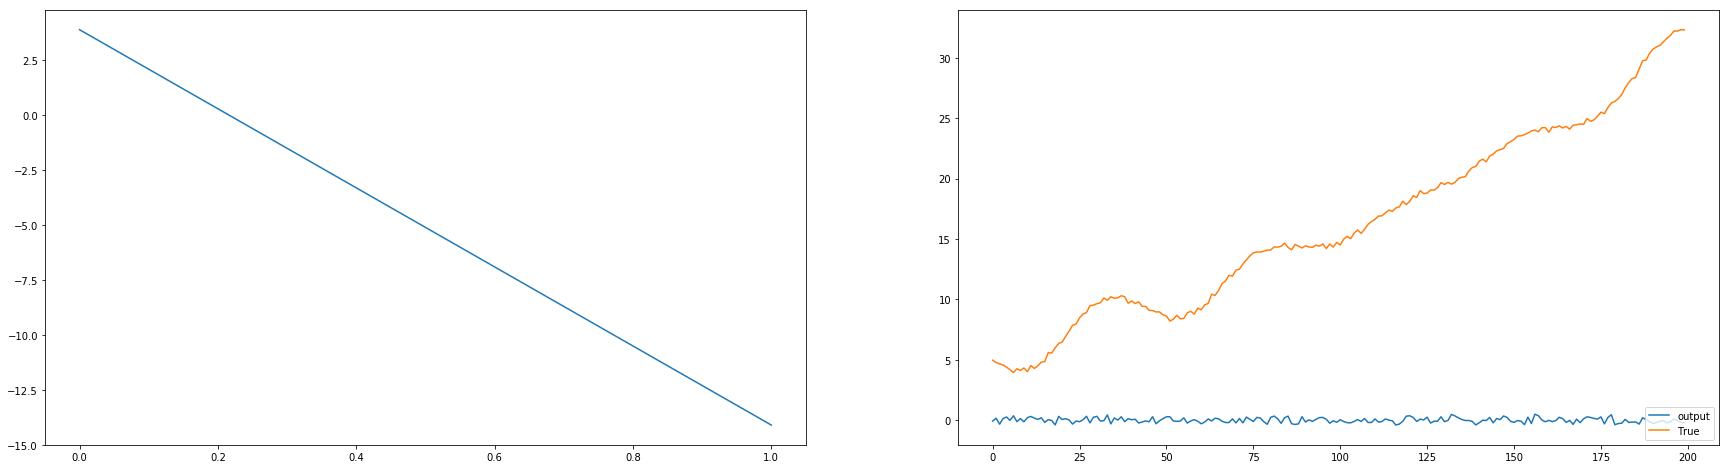

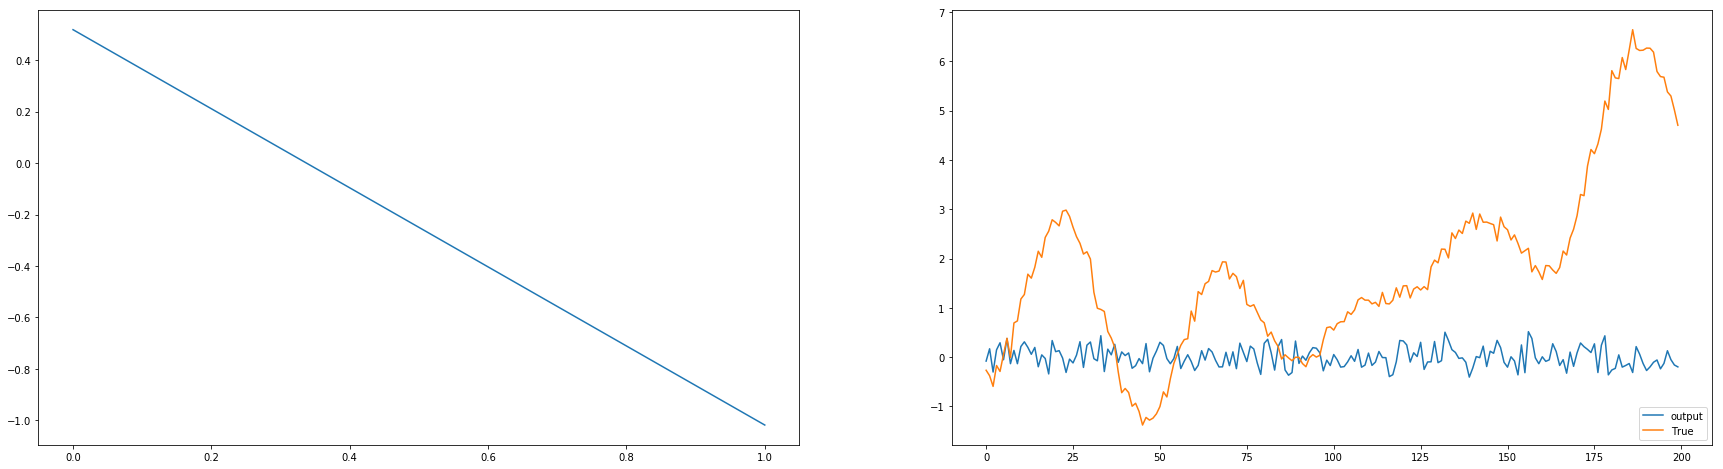

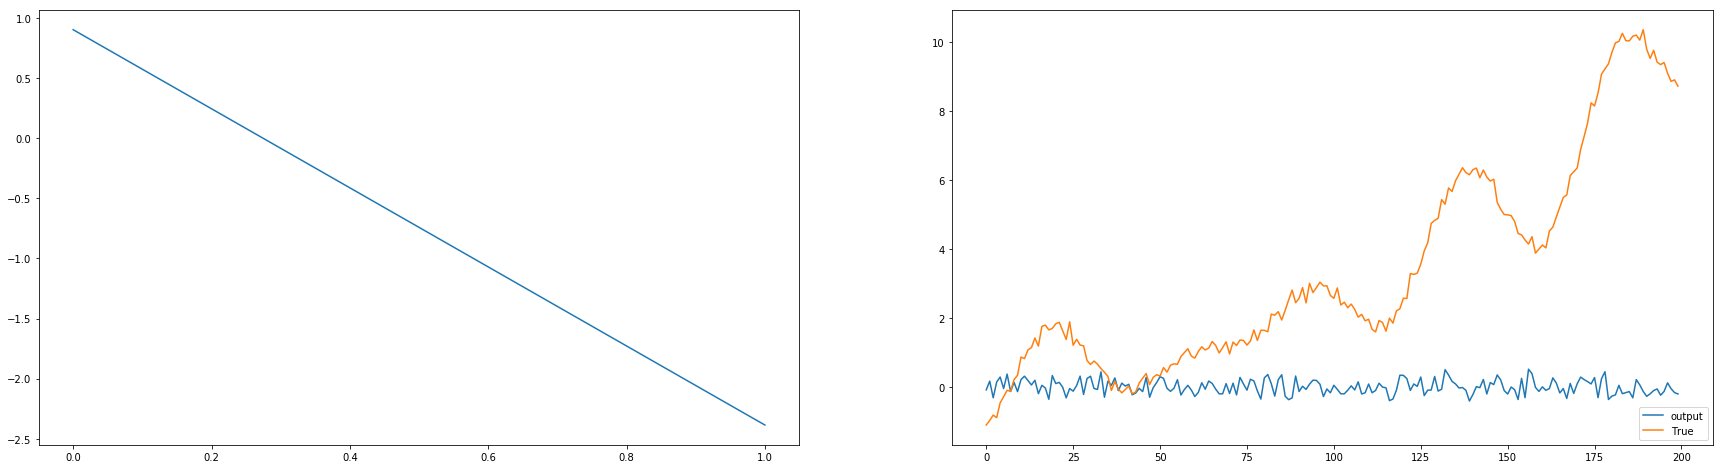

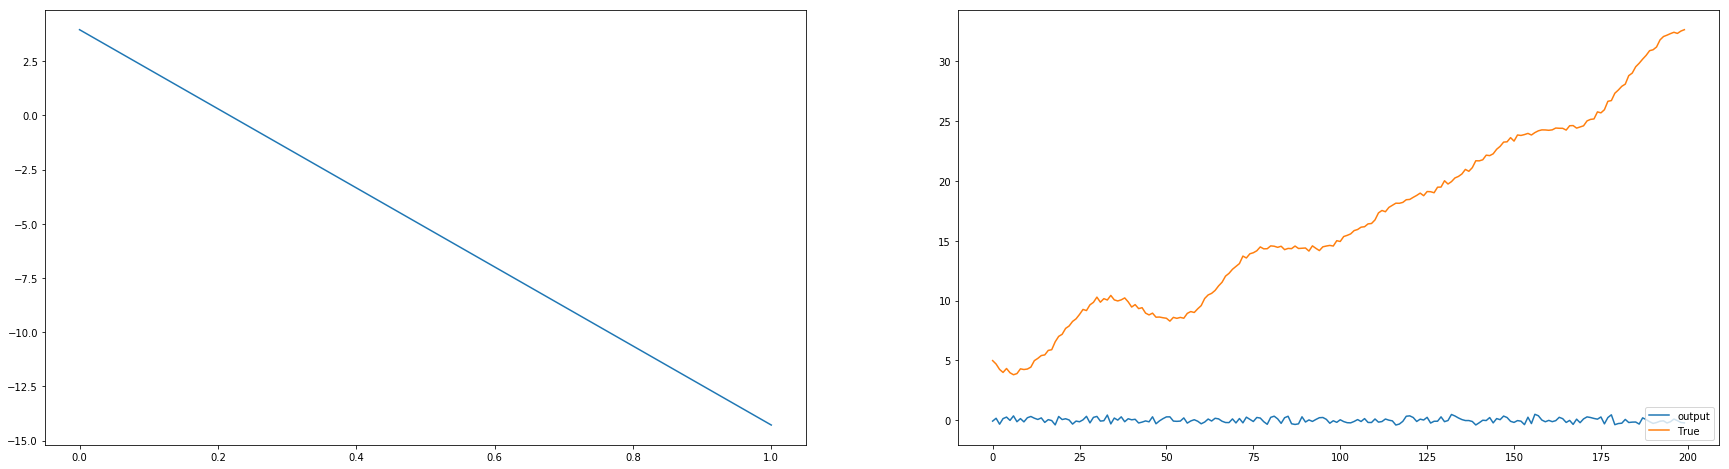

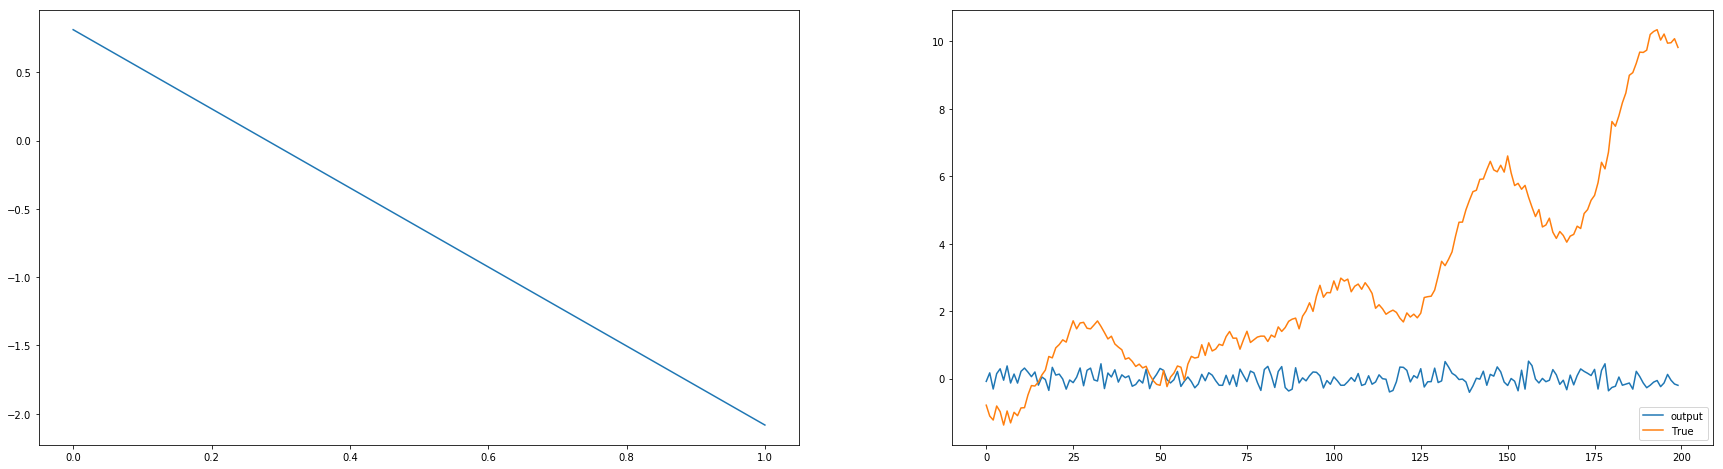

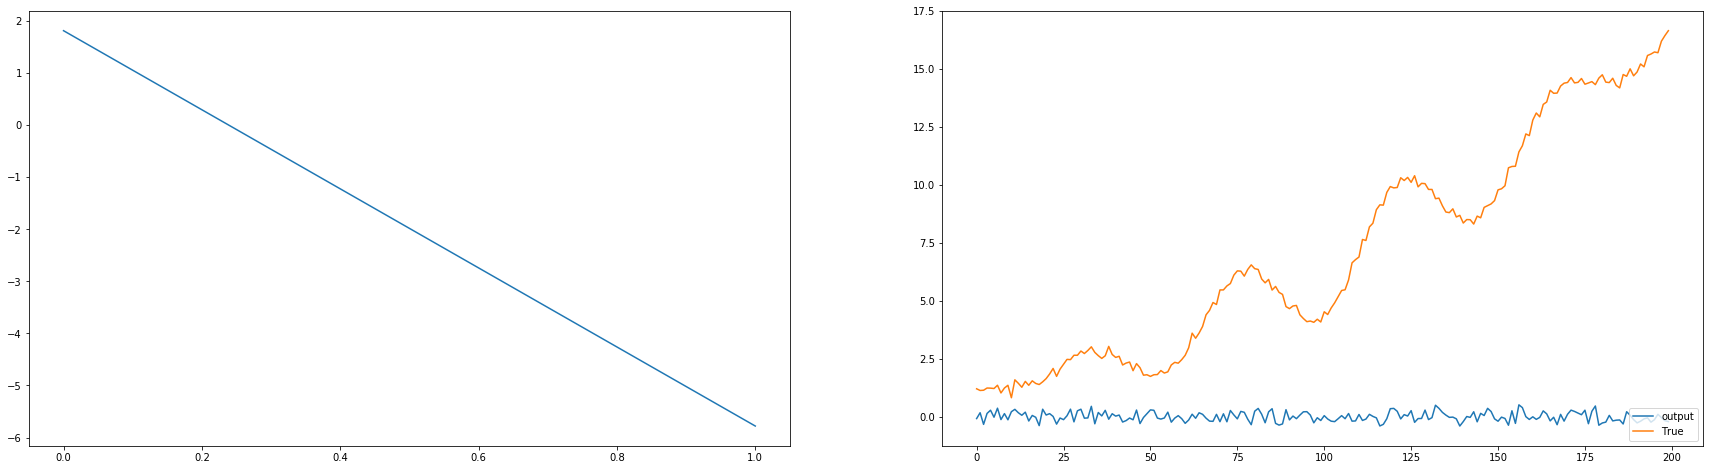

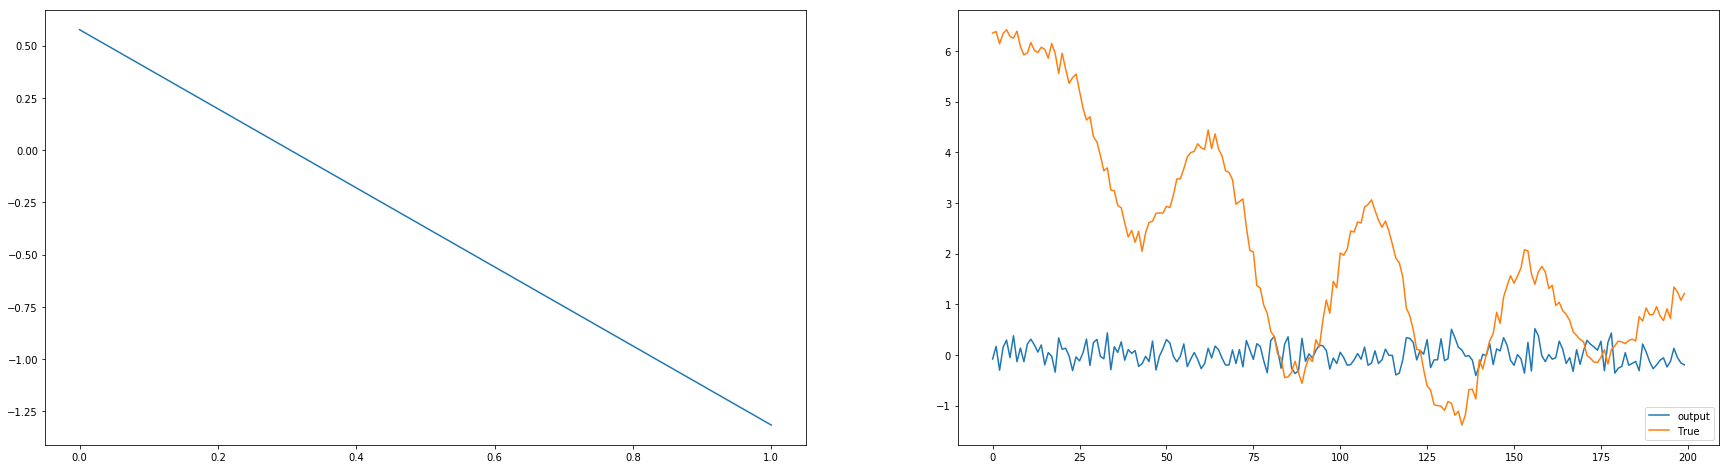

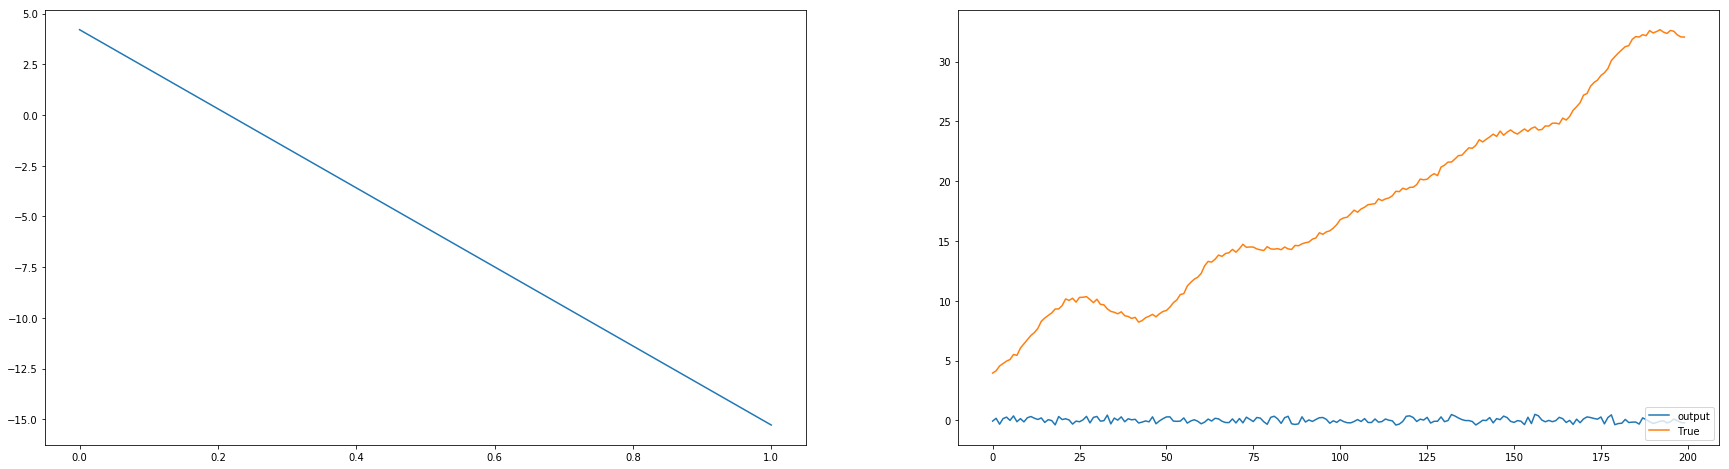

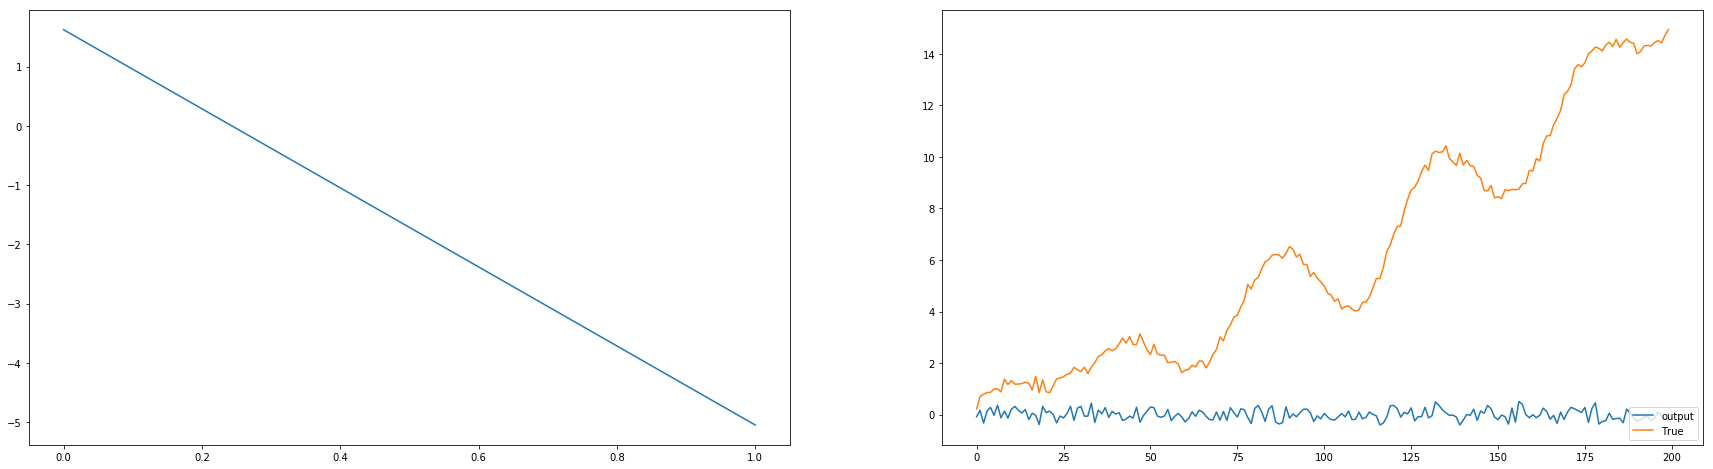

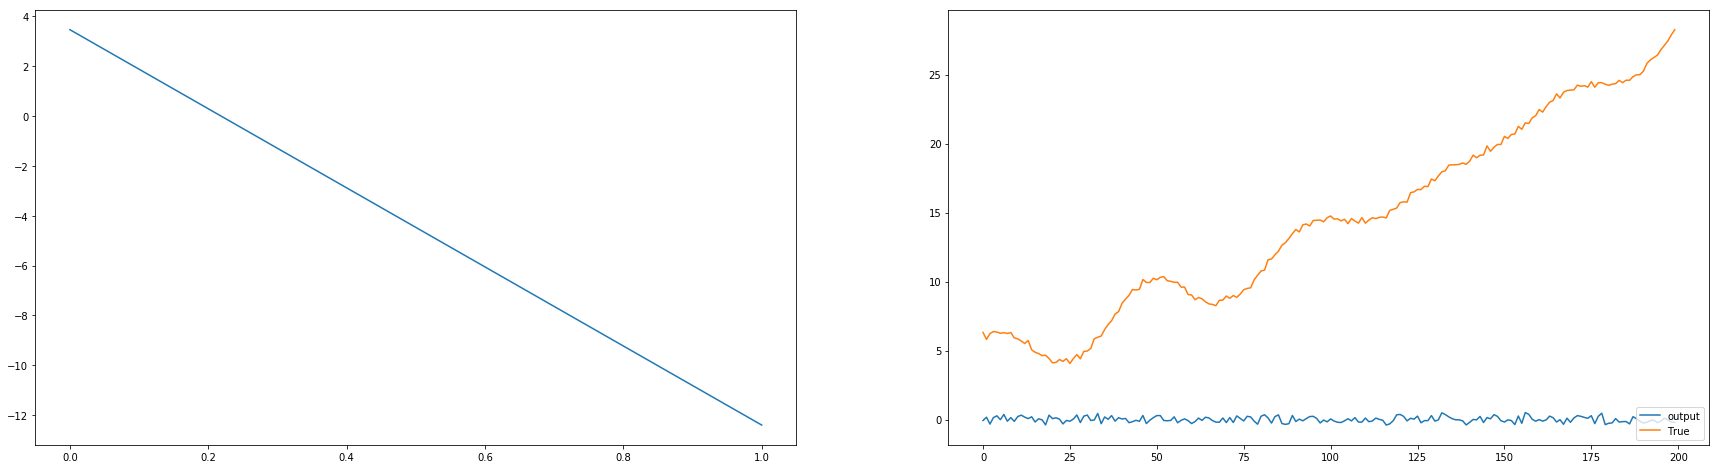

In [25]:
model = Autoencorder_1d(3, 2).to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

loss_list=[]
val_loss_list = []
for epoch in tqdm(range(70000)):
    try:
        model.train()
        index = random.sample([i for i in range(800)], 130)

        tmp_train_data = train_data[index, :,:]
        tmp_train_true = train_true[index, :]
        out1, out2 = model(tmp_train_data)
        loss = criterion(out2, tmp_train_true)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_list.append(loss.item())

        model.eval()
        out1, out2 = model(val_data)
        loss = criterion(out2, val_true)
        val_loss_list.append(loss.item())
    except:
        model.eval()
        out1, out2 = model(val_data)
        loss = criterion(out2, val_true)
        break
    
plt.figure(figsize=(30,5))
plt.plot(loss_list)
plt.plot(val_loss_list)
plt.show()

plt.figure(figsize=(30,5))
plt.plot(loss_list[-50:])
plt.plot(val_loss_list[-50:])
plt.show()

for i in range(10):
    x = val_data[i].cpu().detach().numpy()
    x1 = x[:,0]
    x2 = x[:,1]
    x3 = x[:,2]

    _true = val_true[i].cpu().detach().numpy()
    out = out1[i].cpu().detach().numpy()
    out___2 = out2[i].cpu().detach().numpy()


    plt.figure(figsize=(30,8))
    plt.subplot(1,2,1)
    plt.plot(out)
    plt.subplot(1,2,2)
    plt.plot(out___2, label='output')
    plt.plot(_true, label='True')
    plt.legend(loc=4)
    plt.show()

In [ ]:
out1 = out1.detach().numpy()
out2 = out2.detach().numpy()
k = KMeans(25)
label = k.fit_predict(out1)

In [ ]:
df = pd.DataFrame()
df['out1'] = out1[:,0]
df['out2'] = out1[:,1]
df['label'] =label
df.head()

"\ntry:\n    plt.subplot(1,3,2)\n    sns.scatterplot(data=df, x='out2', y='out3', hue='label')\n    plt.subplot(1,3,3)\n    sns.scatterplot(data=df, x='out3', y='out1', hue='label')\nexcept:\n    pass\n"

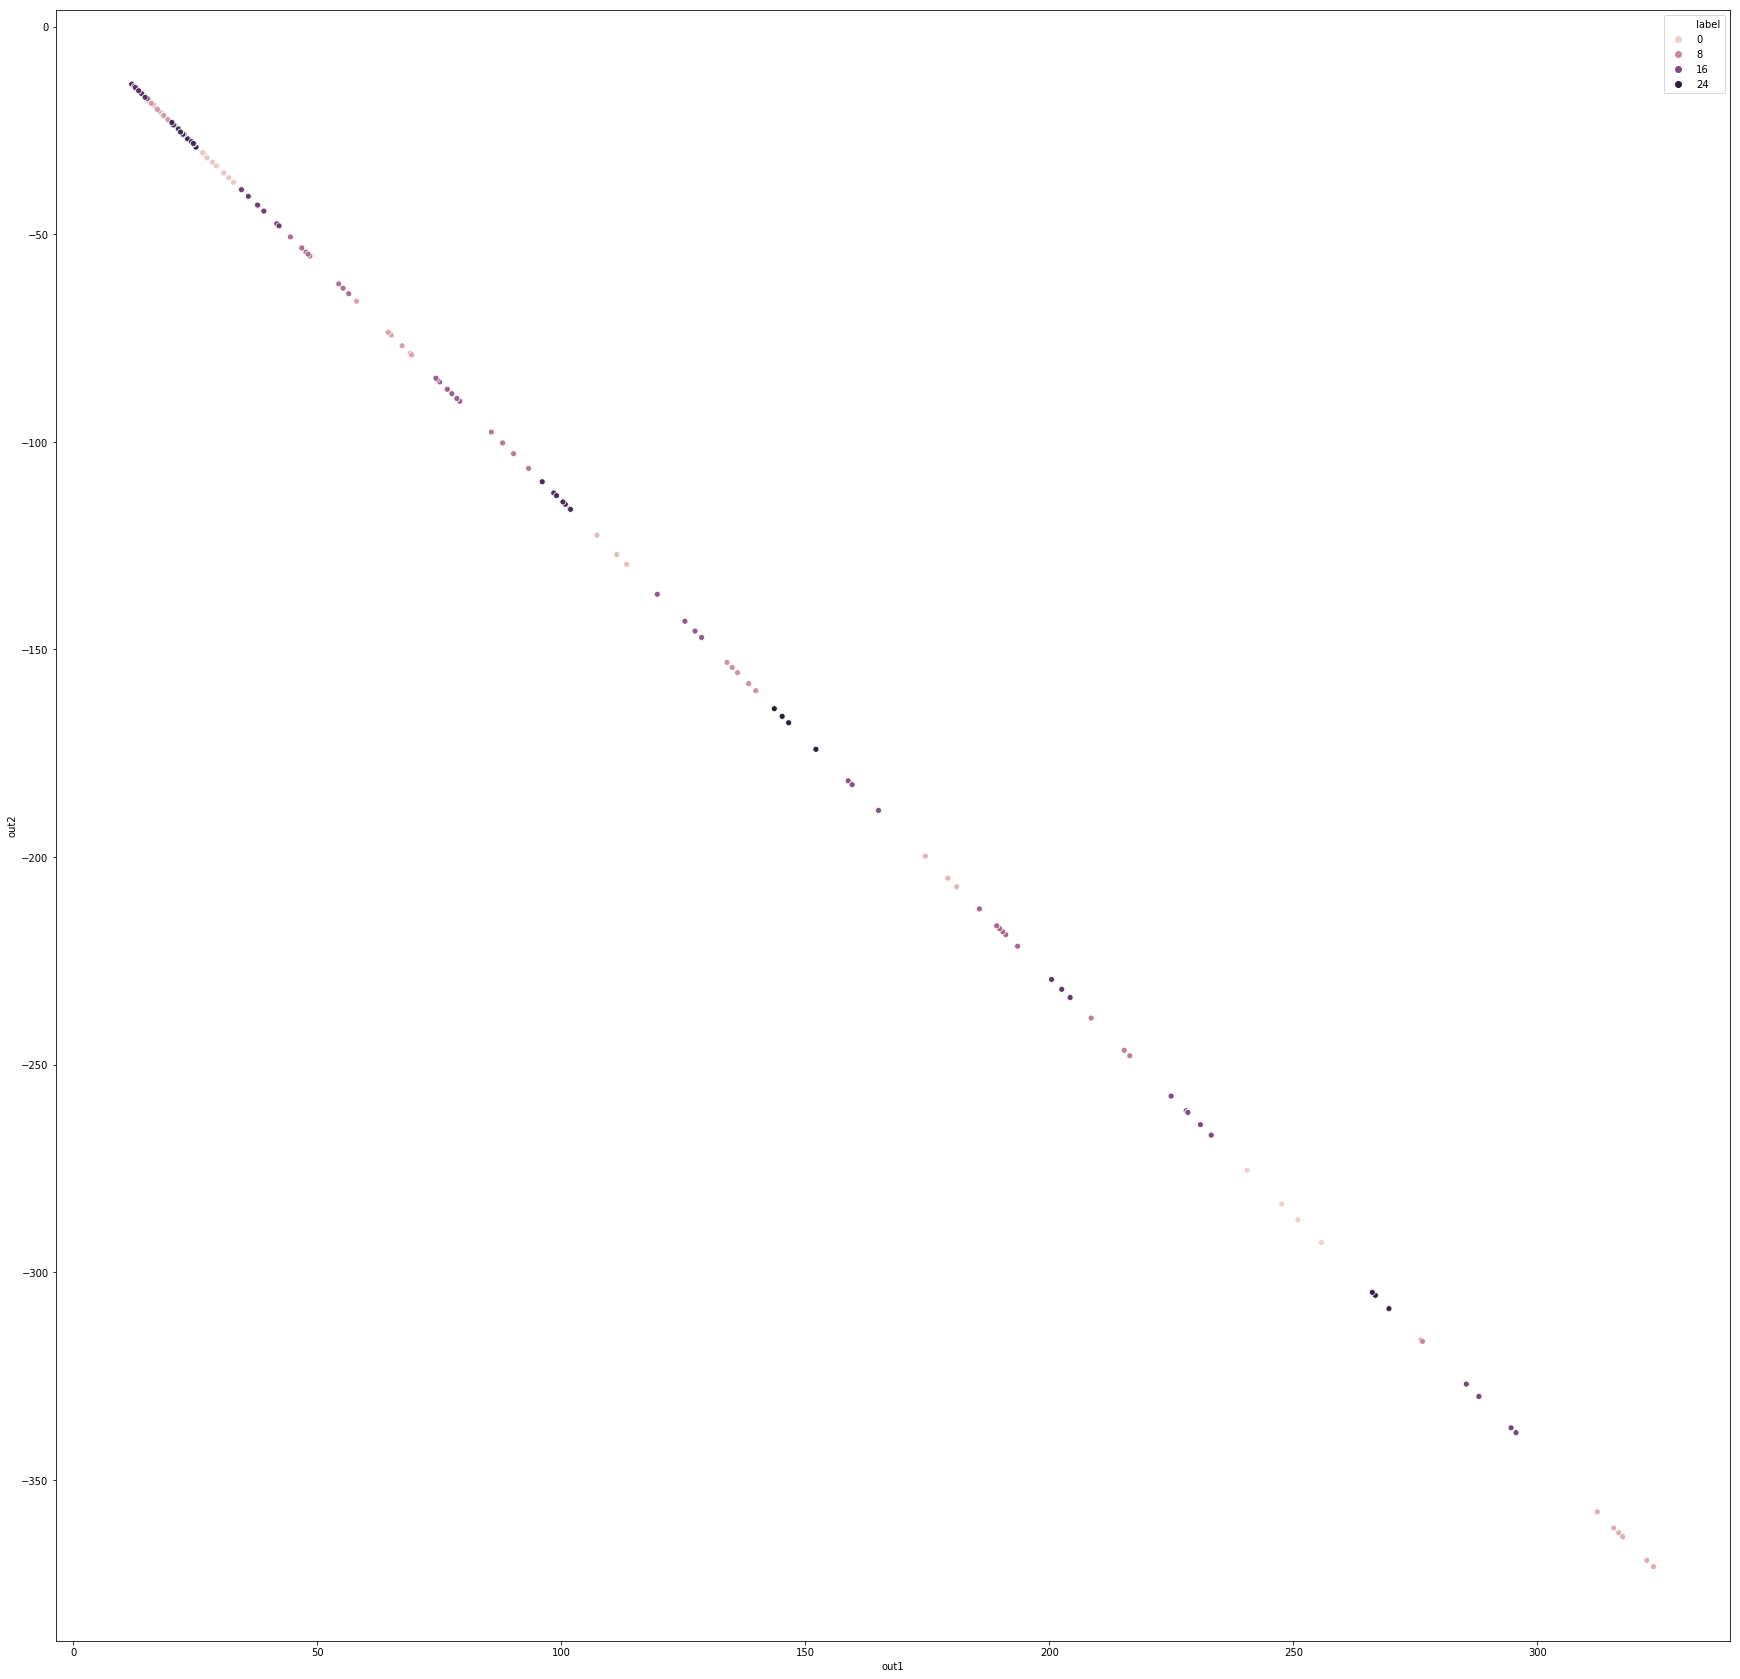

In [14]:
plt.figure(figsize=(30,30))
#plt.subplot(1,3,1)
sns.scatterplot(data=df, x='out1', y='out2', hue='label')
"""
try:
    plt.subplot(1,3,2)
    sns.scatterplot(data=df, x='out2', y='out3', hue='label')
    plt.subplot(1,3,3)
    sns.scatterplot(data=df, x='out3', y='out1', hue='label')
except:
    pass
"""

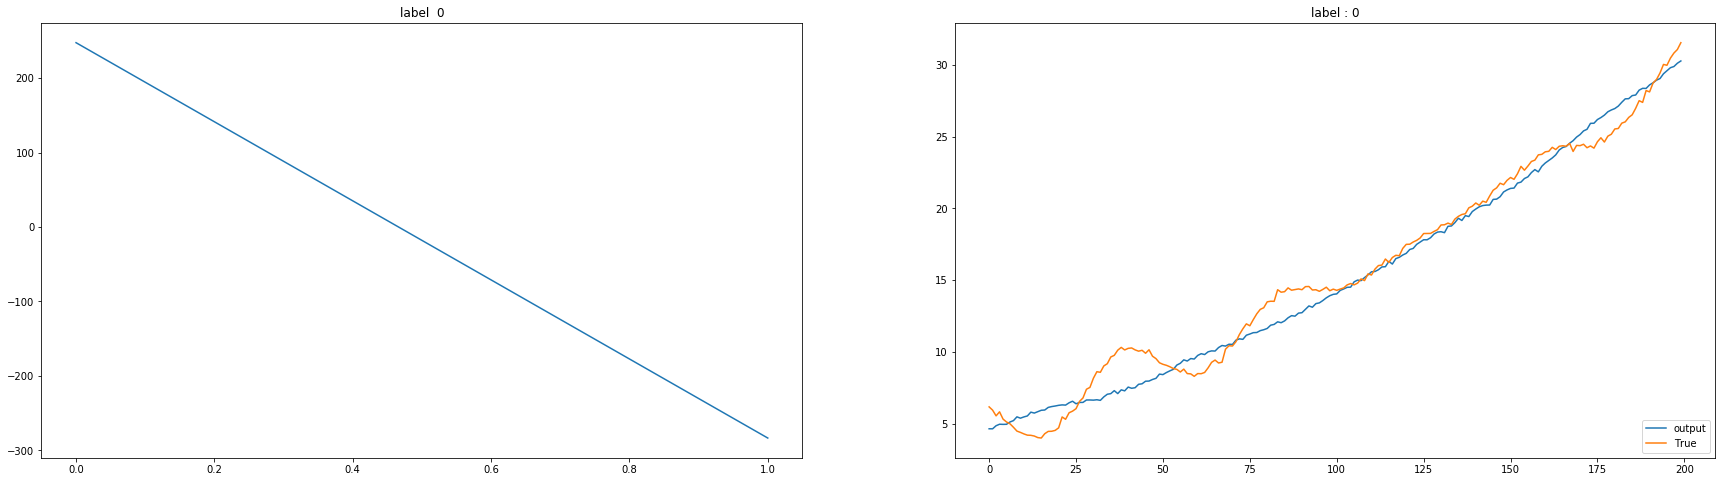

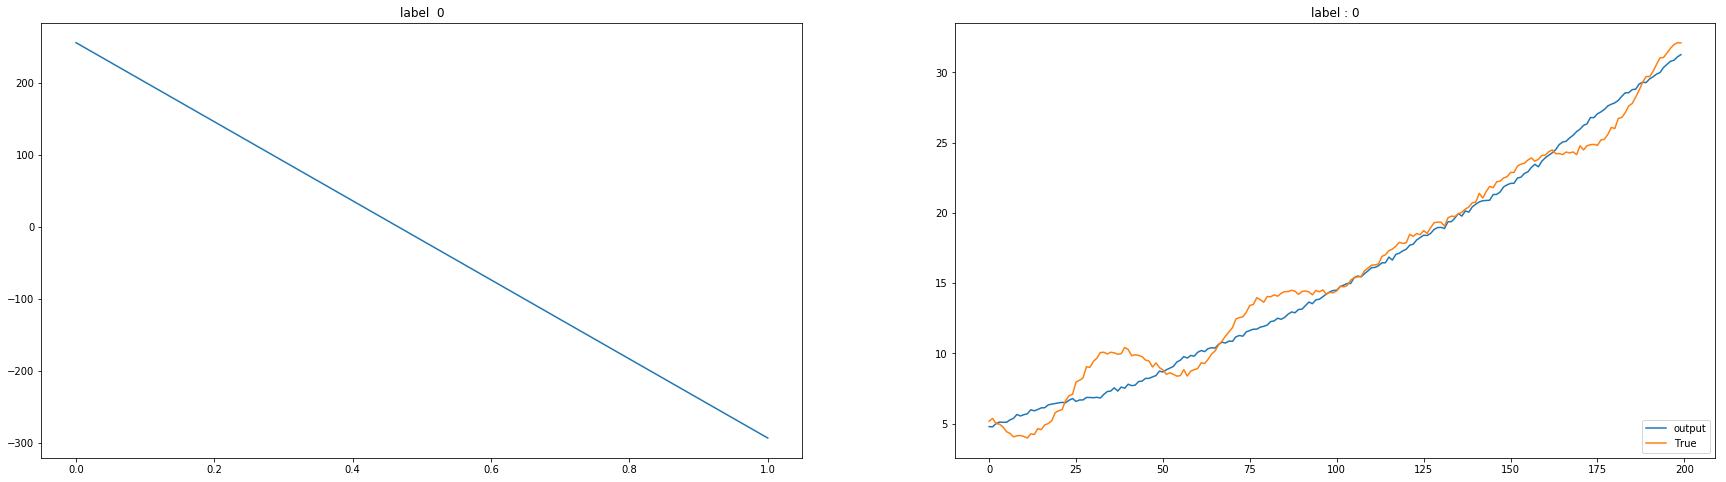

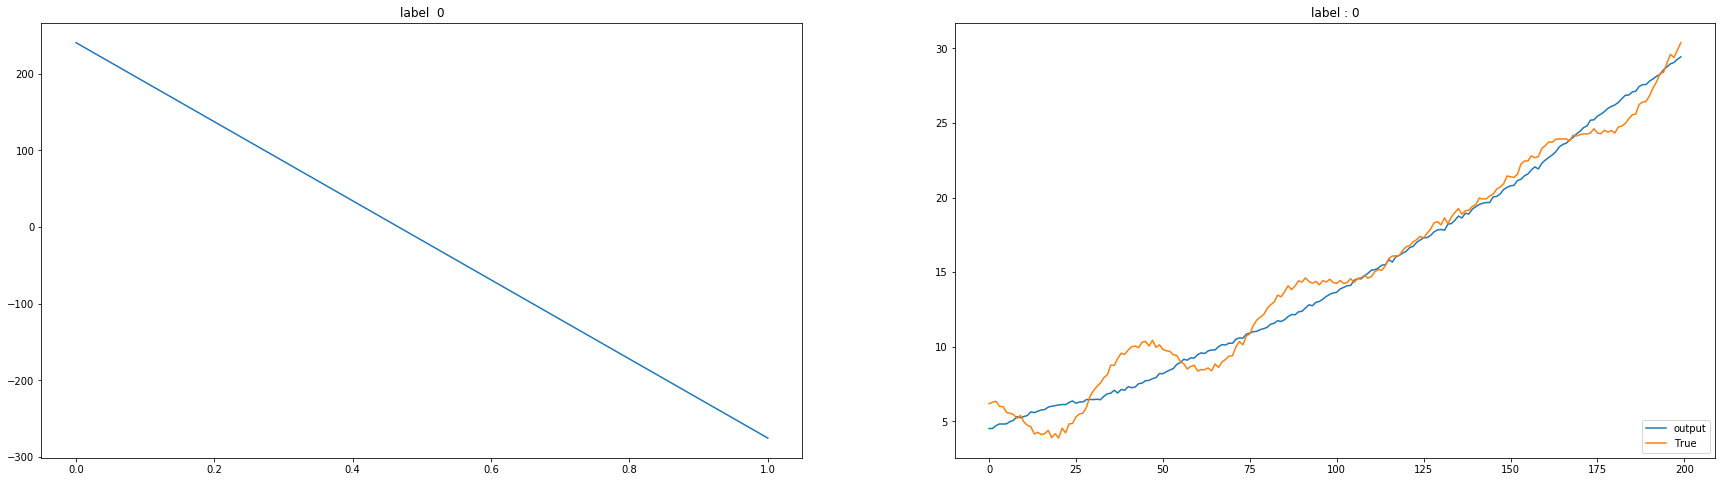

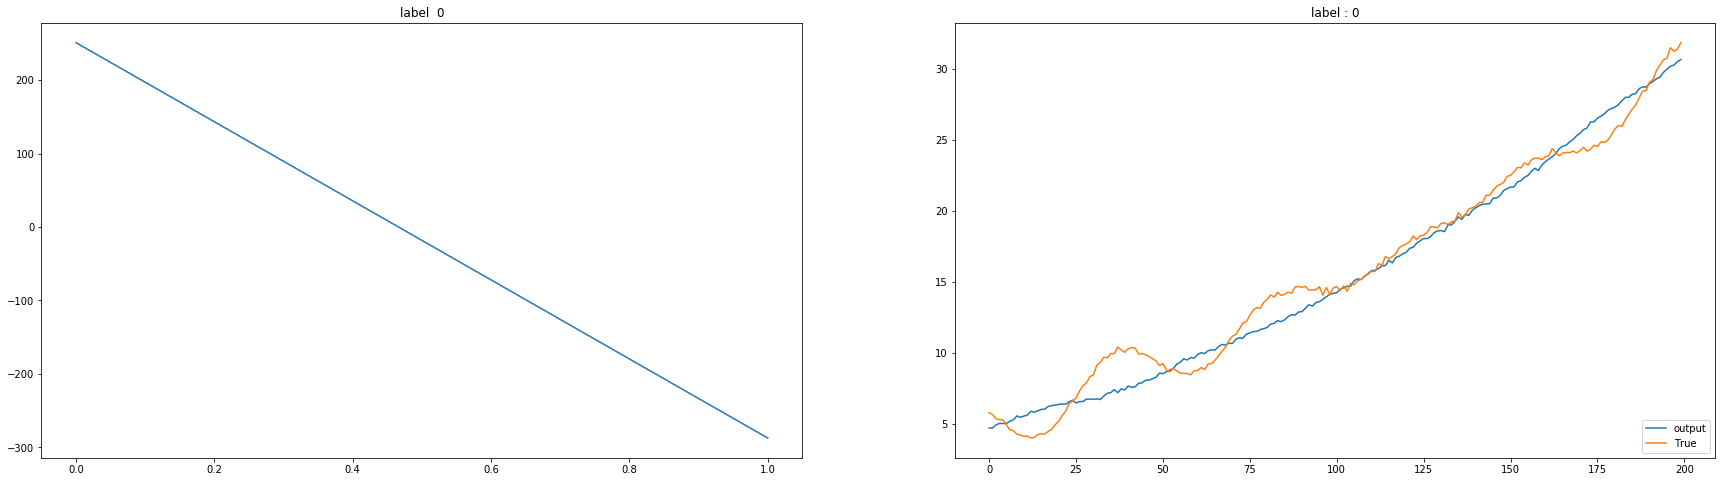

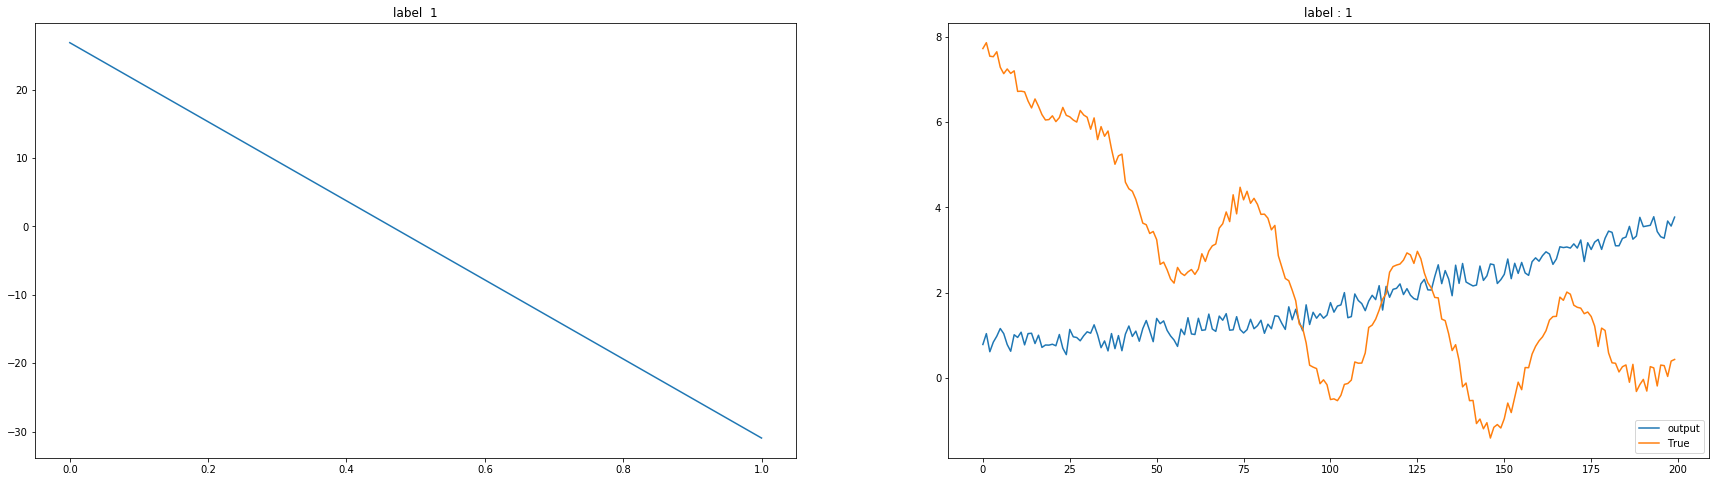

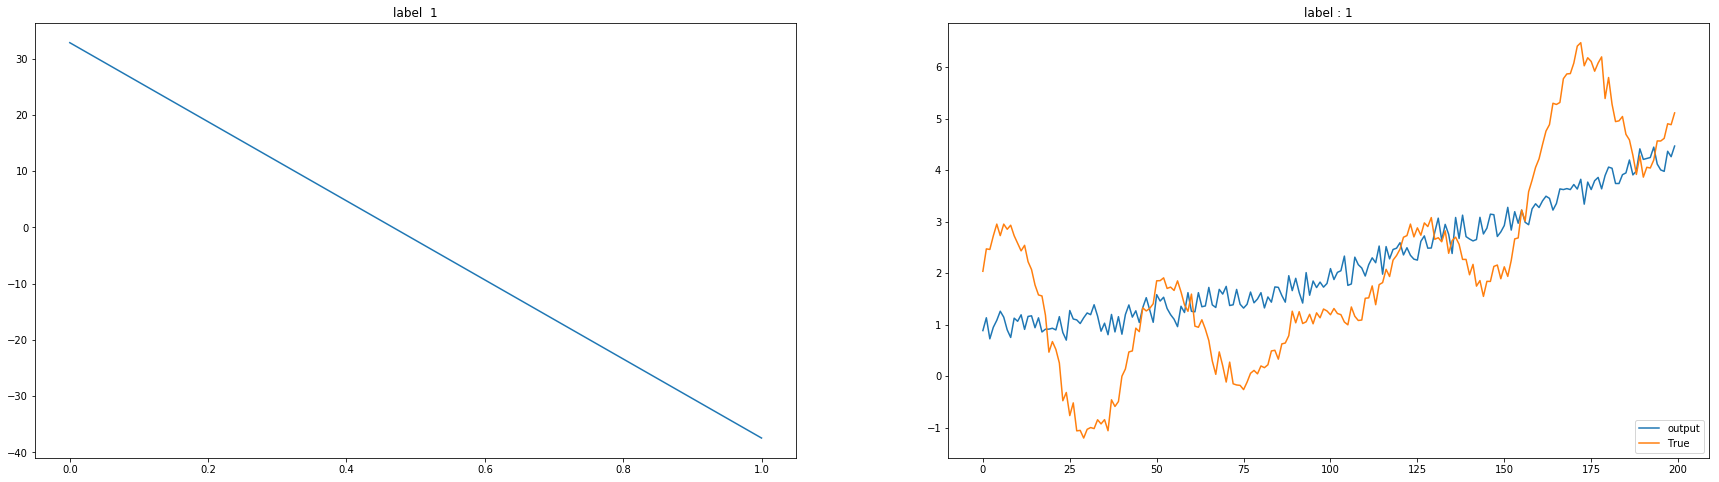

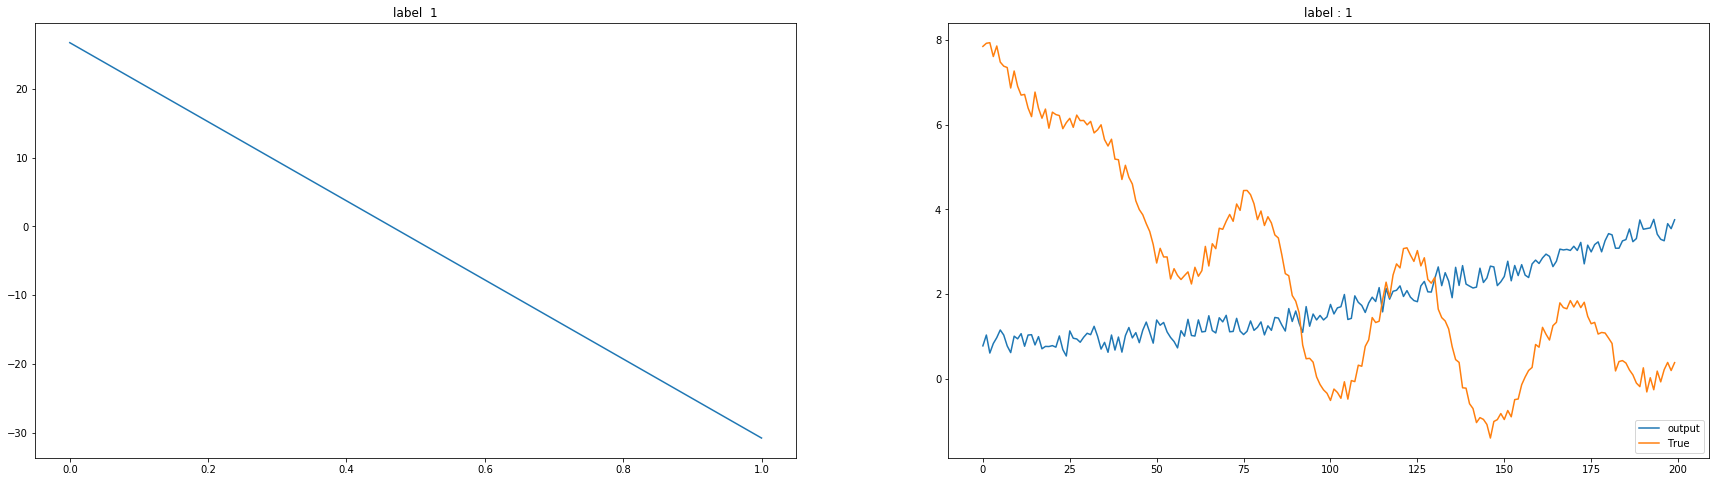

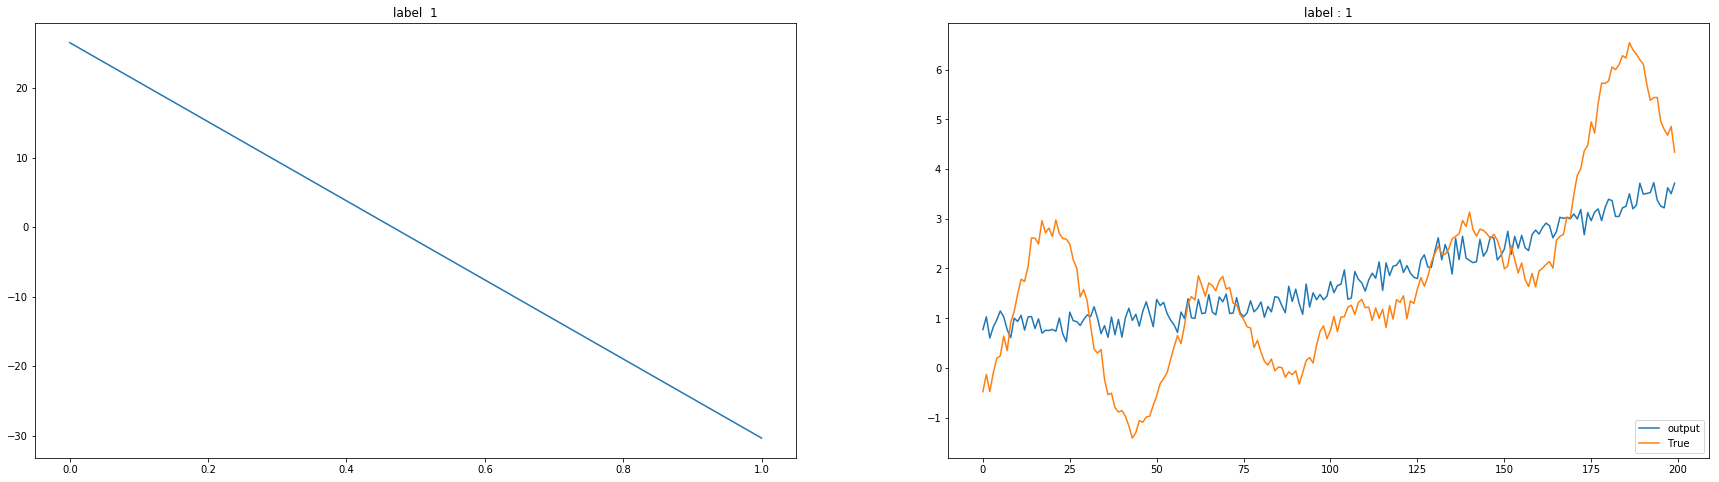

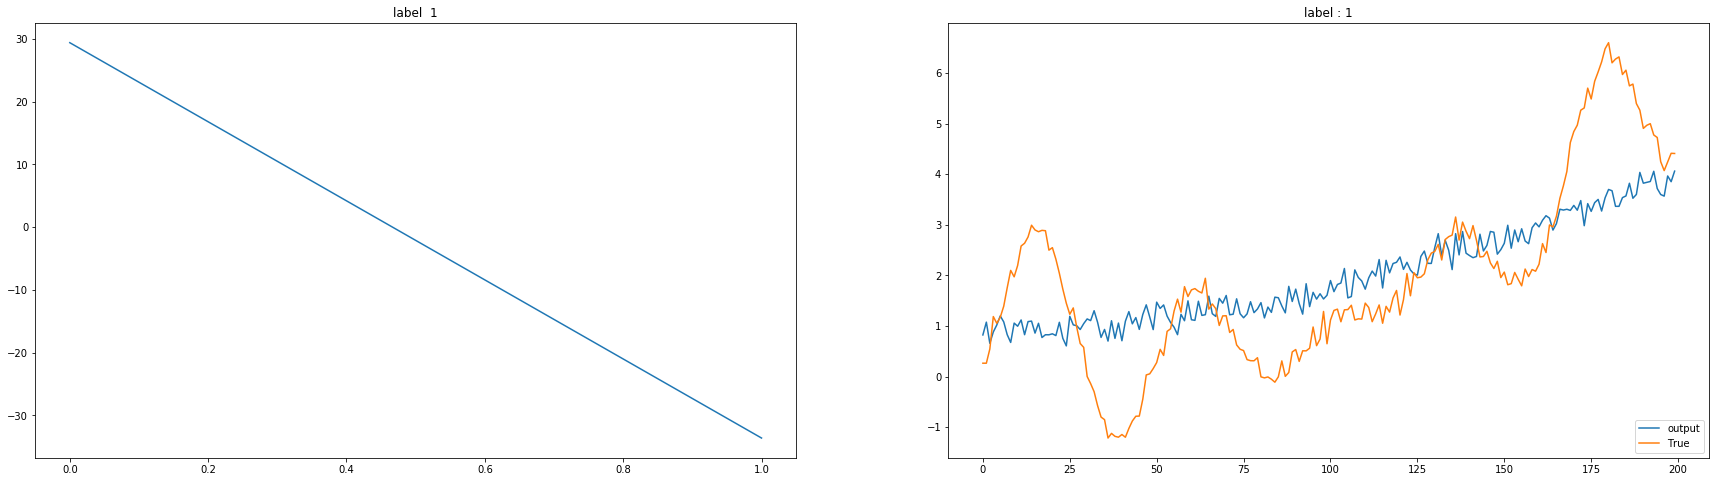

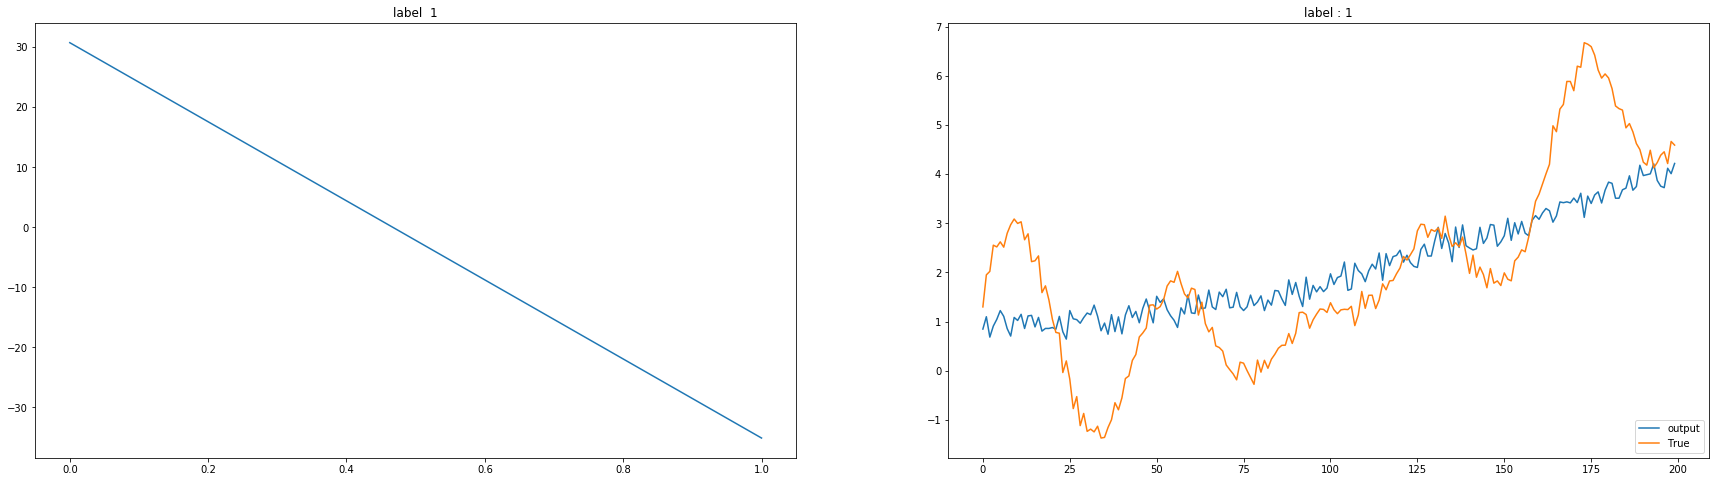

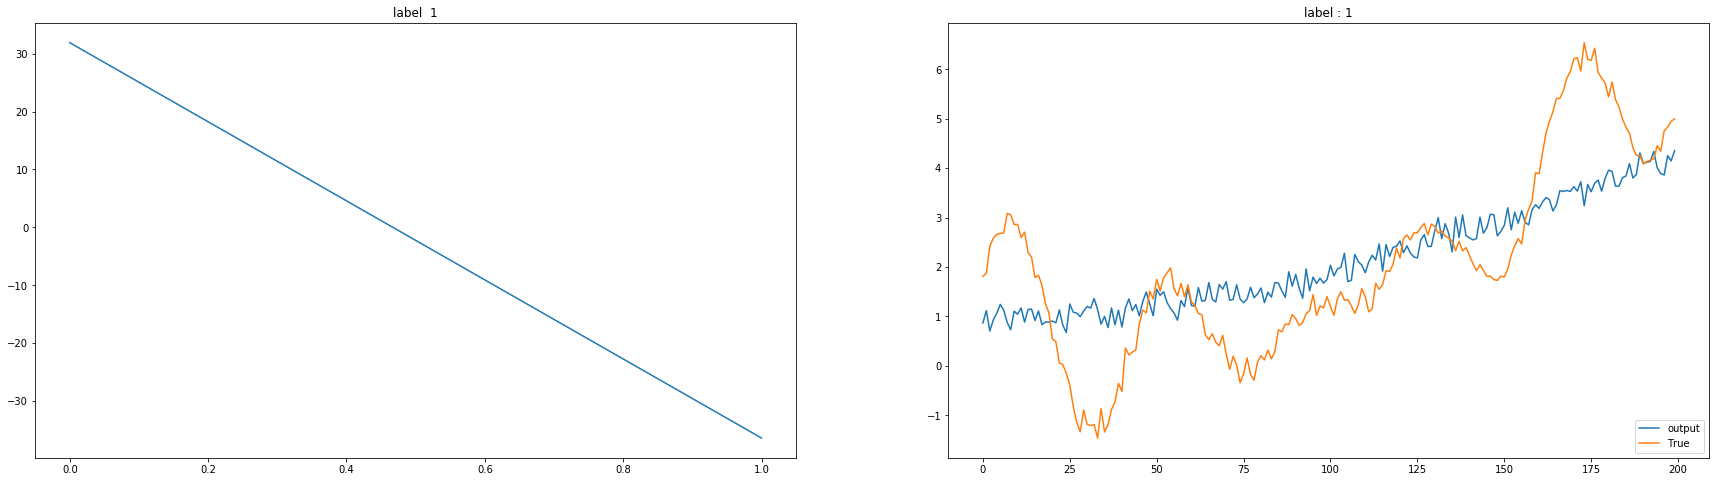

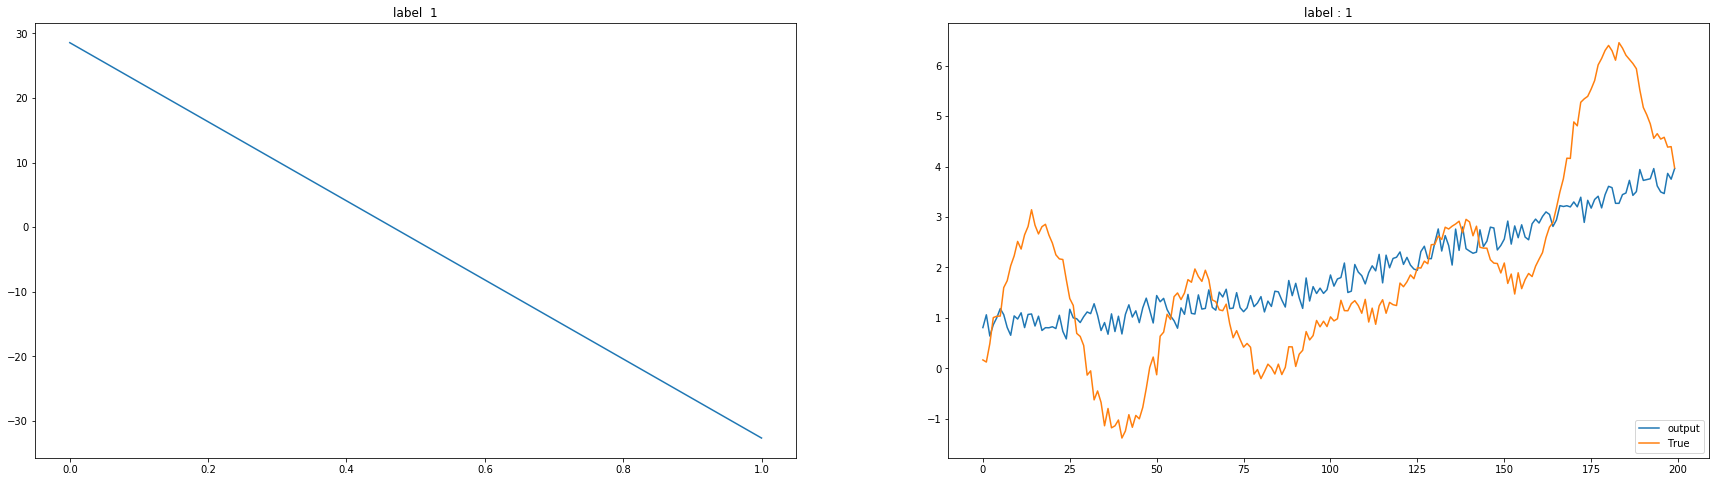

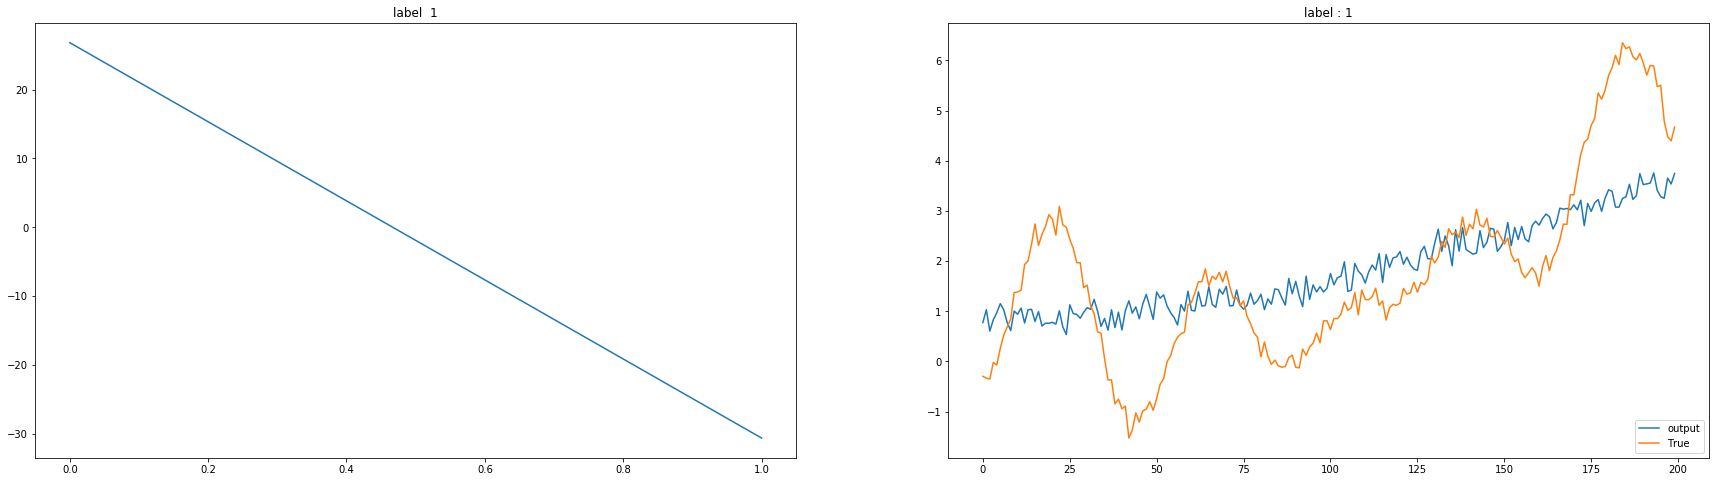

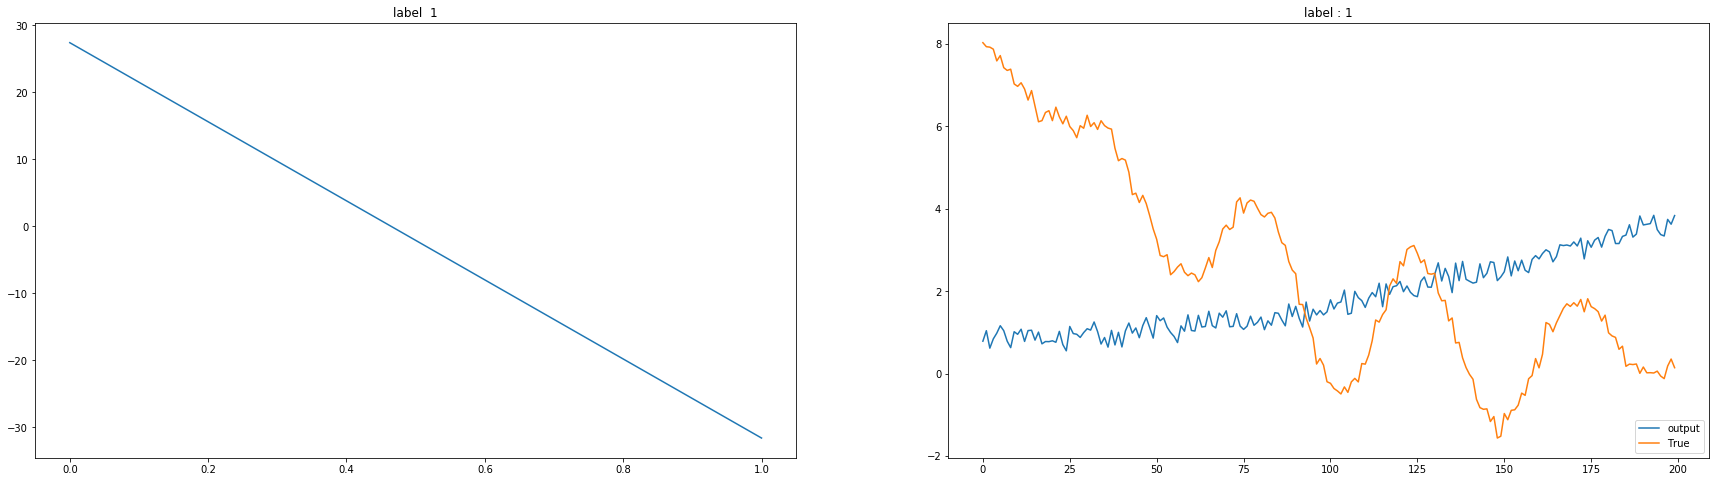

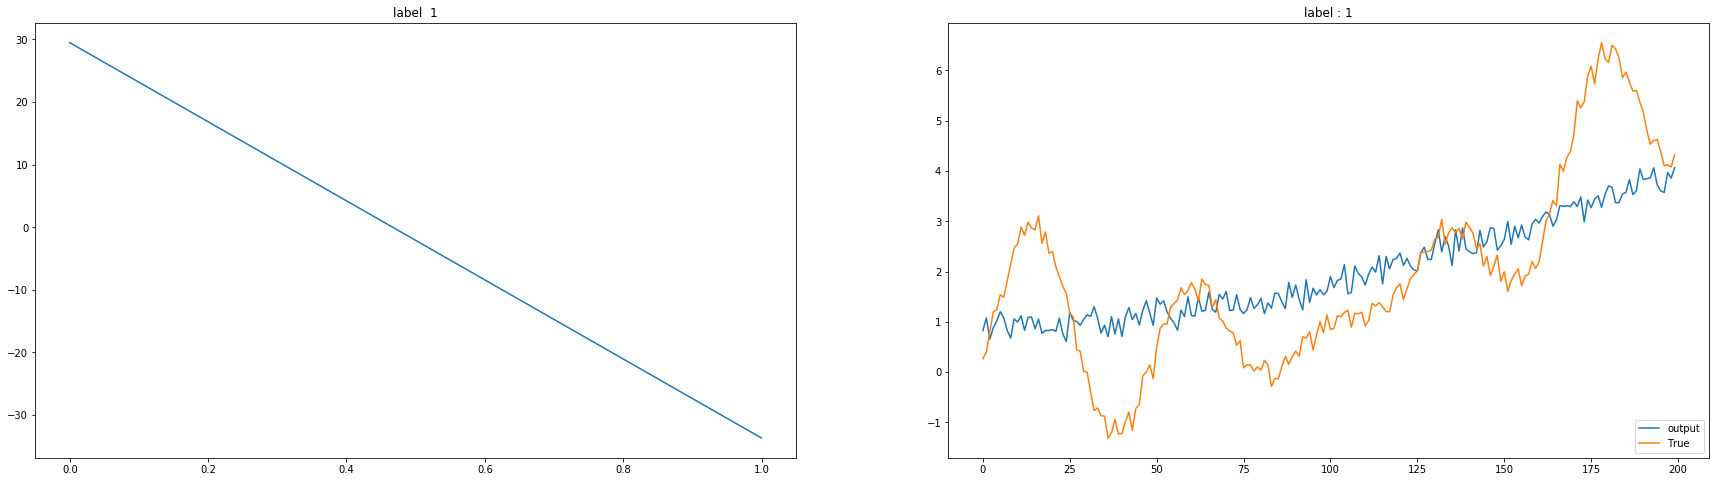

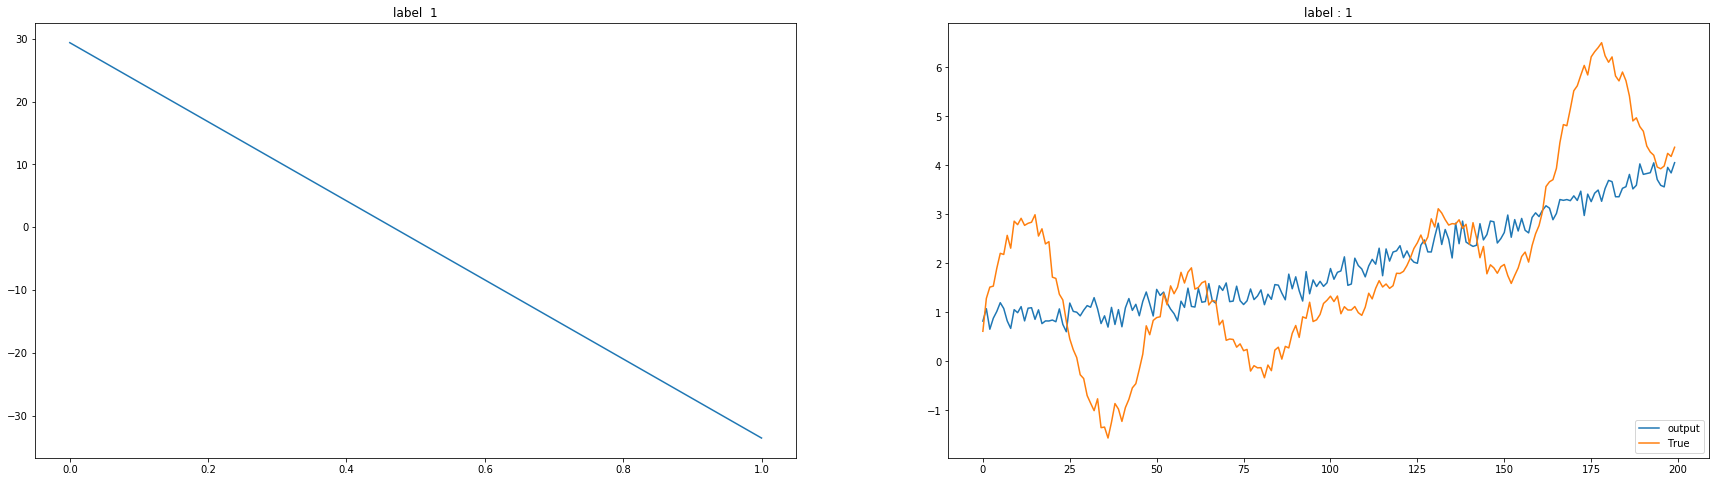

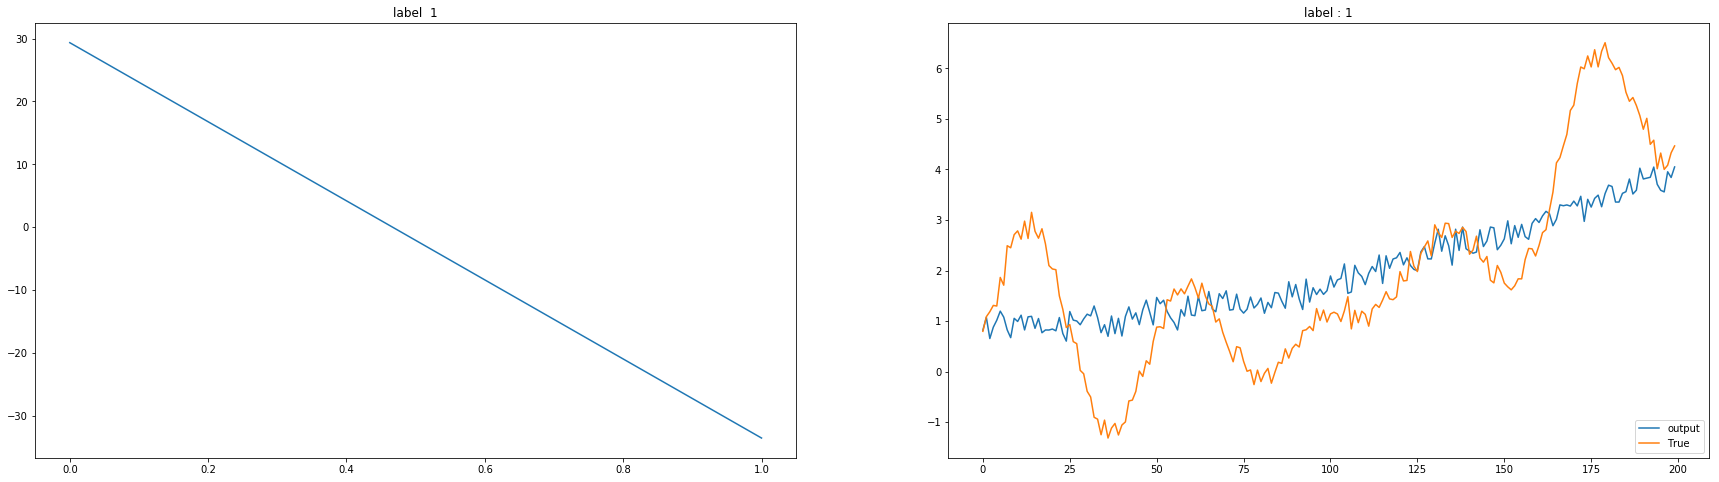

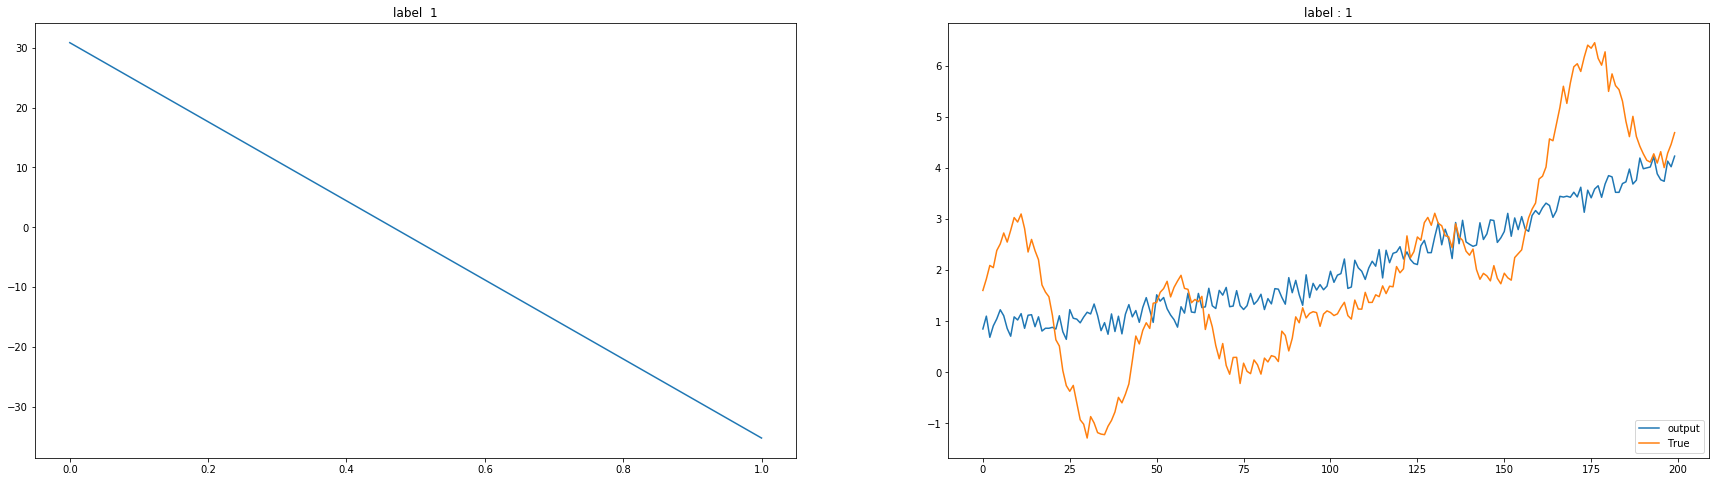

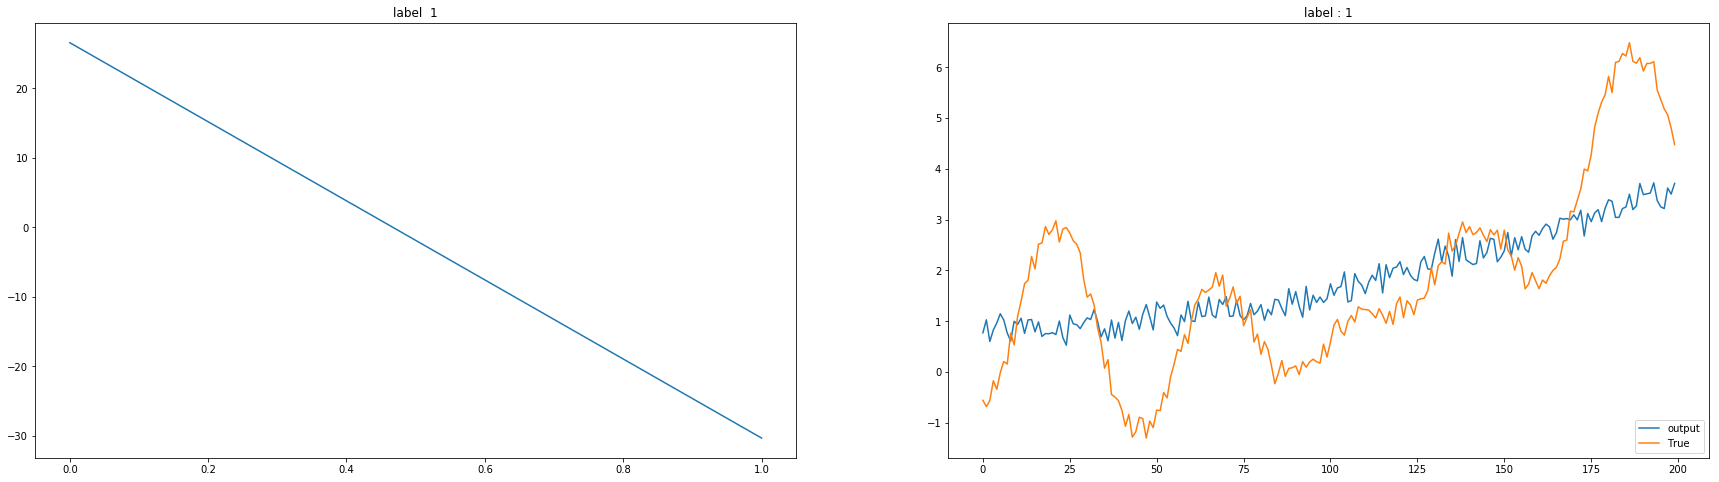

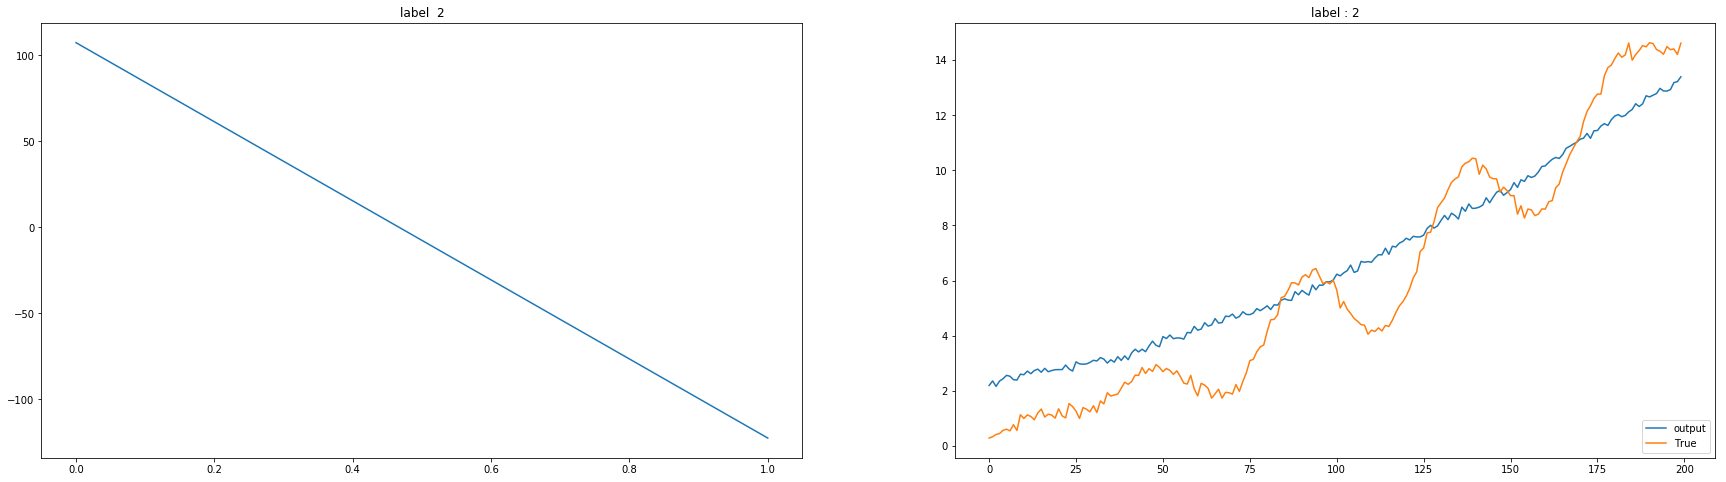

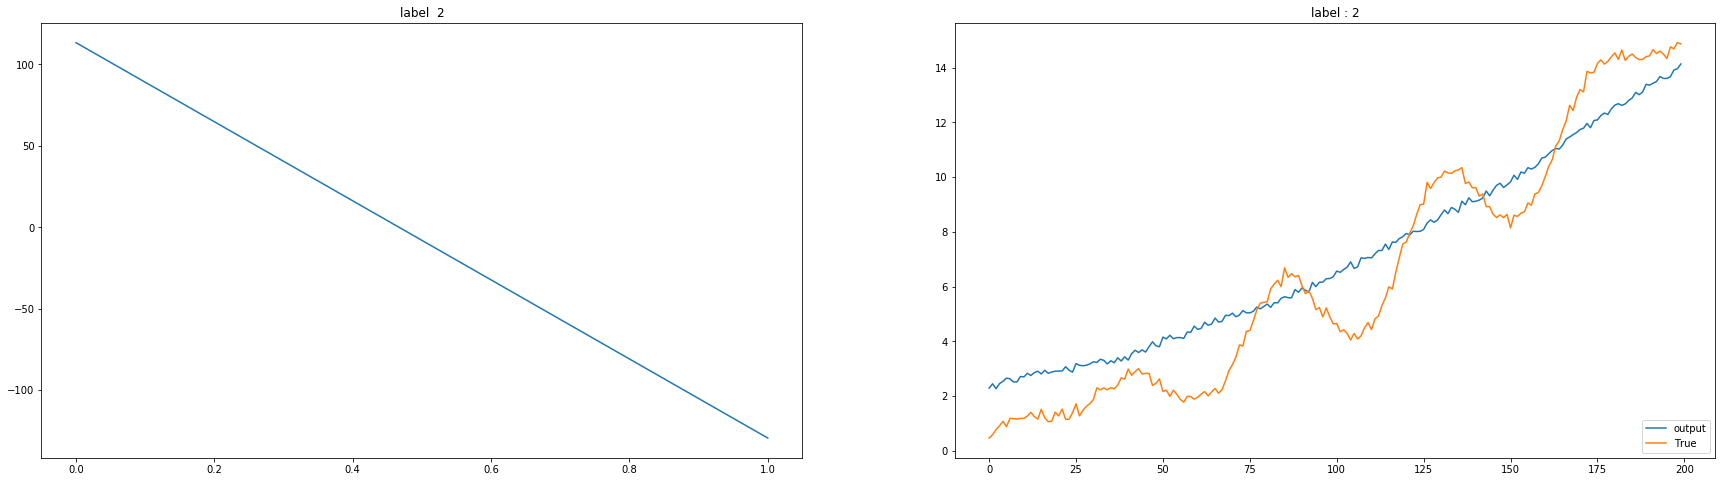

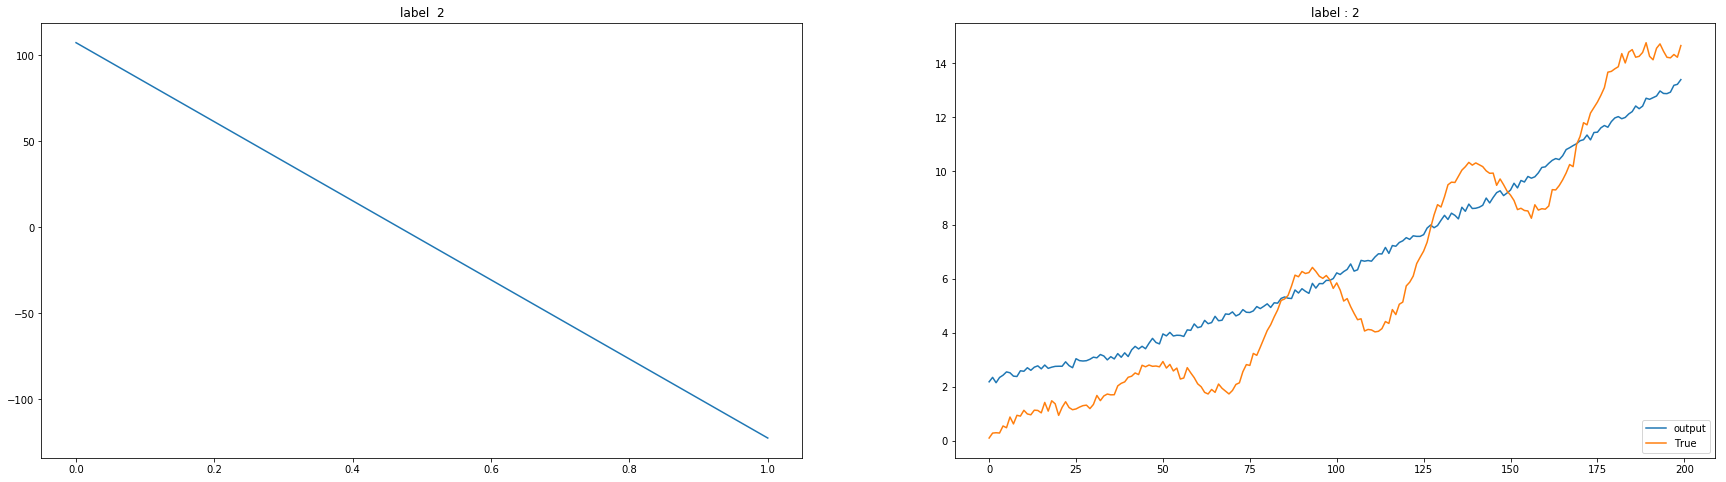

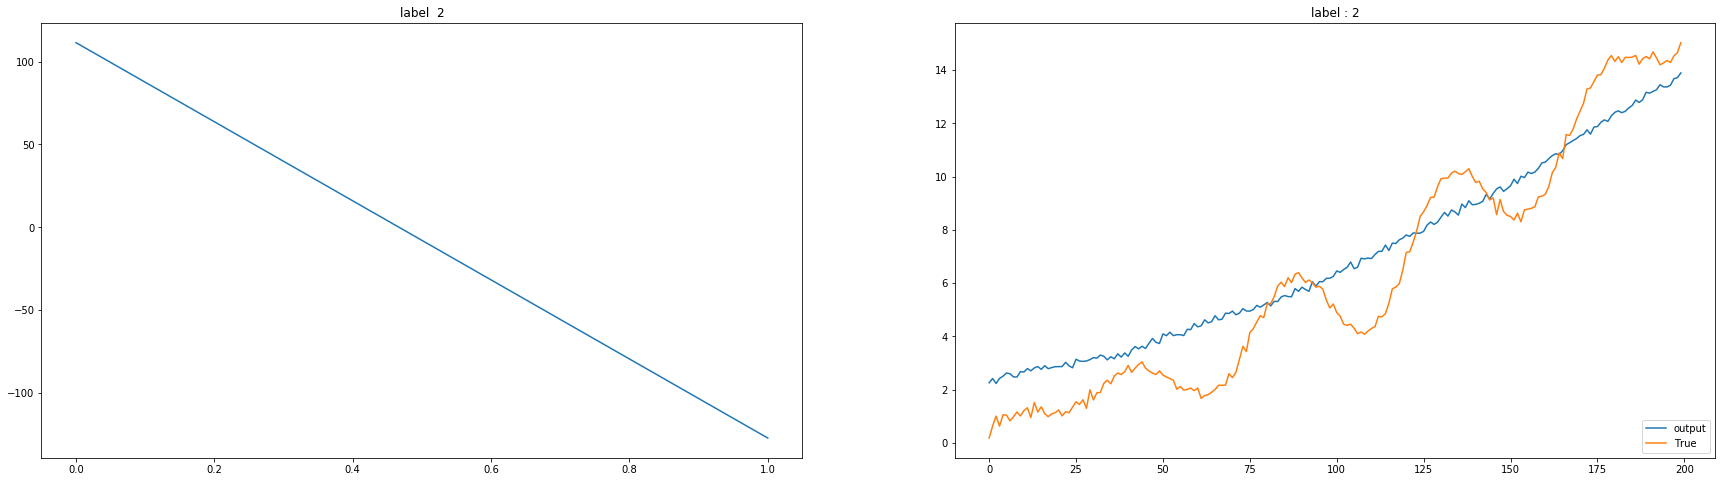

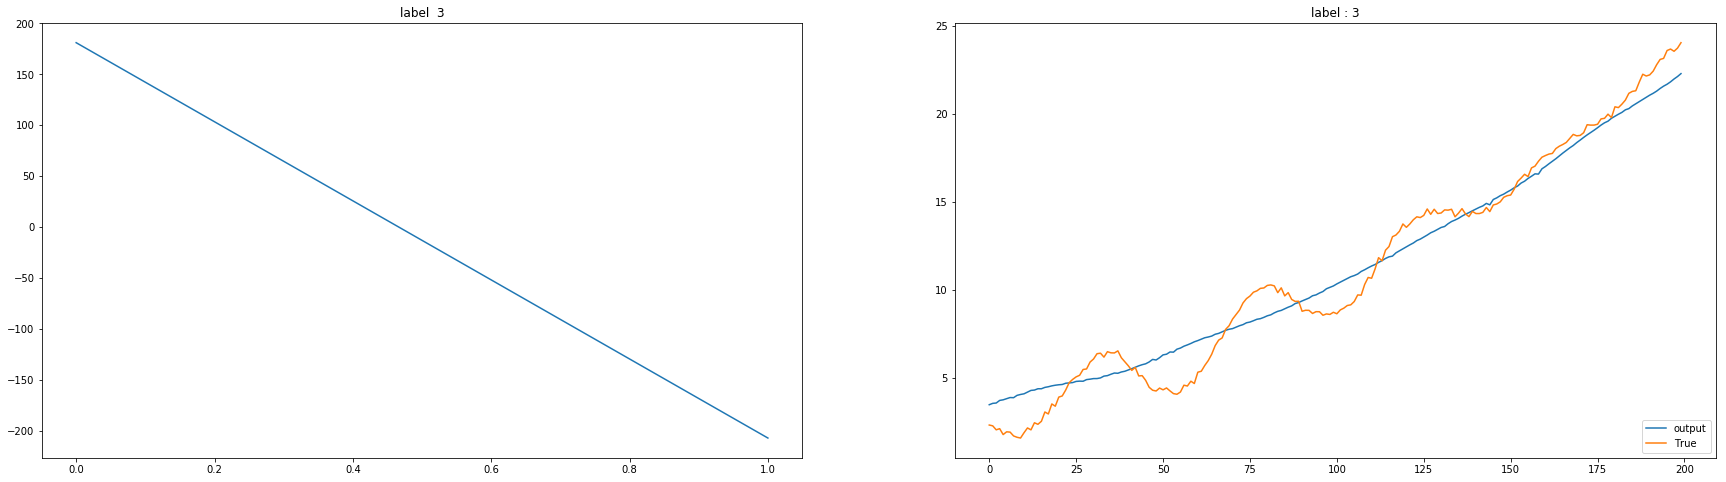

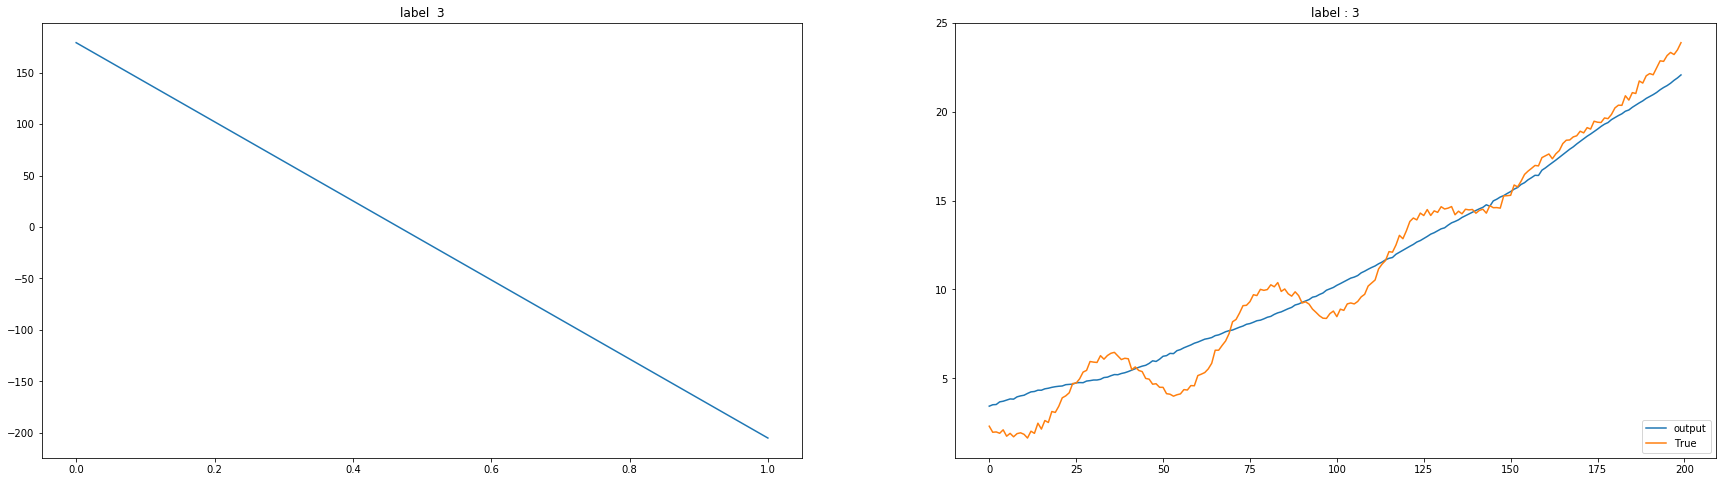

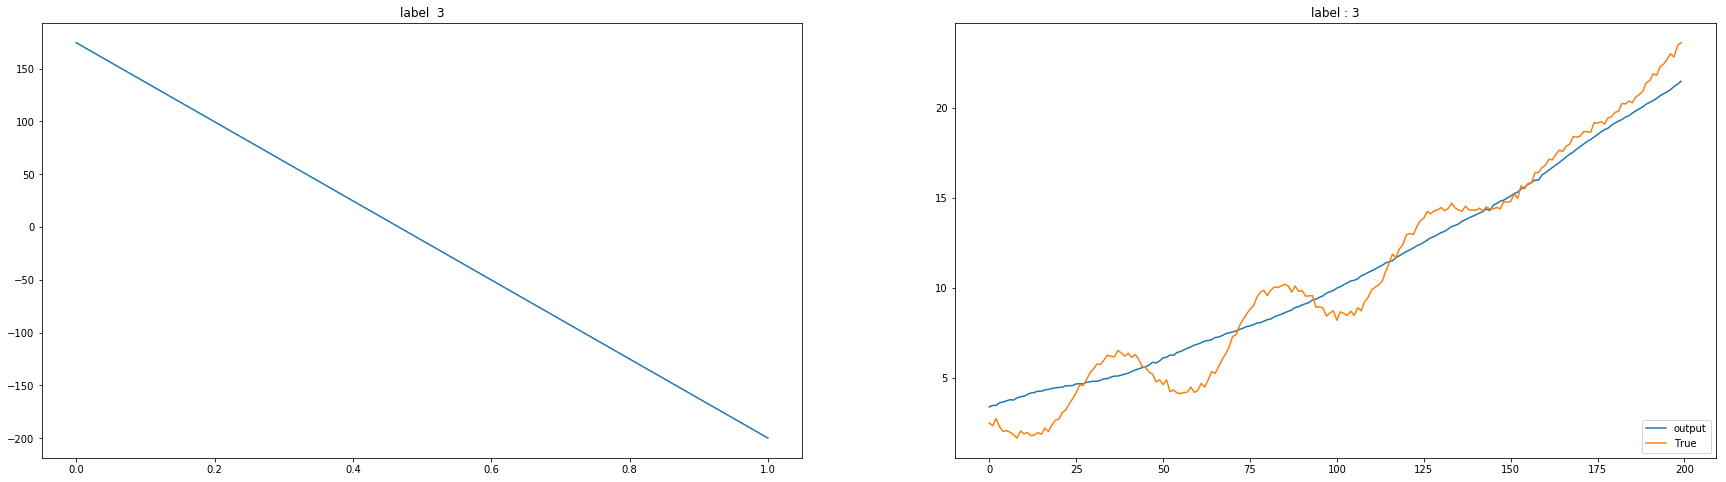

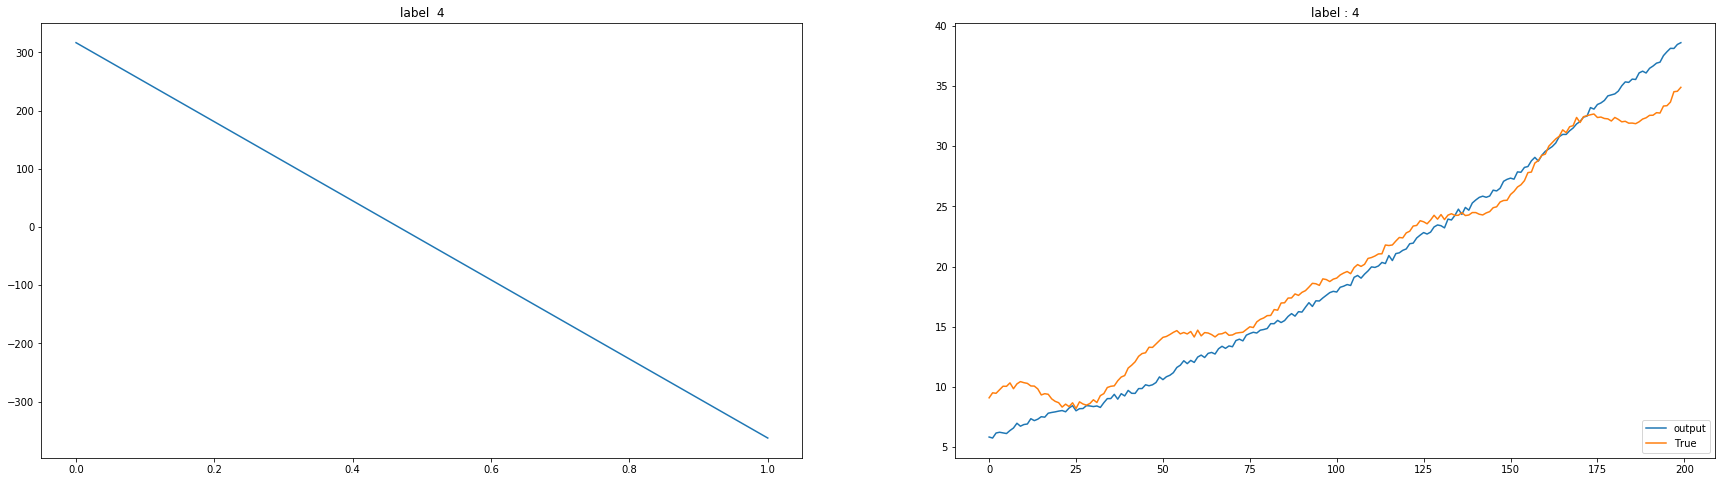

KeyboardInterrupt: 

In [15]:
for label in range(10):
    for i in df[df.label==label].index:
        _true = val_true[i].detach().numpy()
        tmp_out1 = out1[i]
        tmp_out2 = out2[i]


        plt.figure(figsize=(30,8))
        plt.subplot(1,2,1)
        plt.plot(tmp_out1)
        plt.title(f'label  {label}')
        plt.subplot(1,2,2)
        plt.plot(tmp_out2, label='output')
        plt.plot(_true, label='True')
        plt.legend(loc=4)
        plt.title(f'label : {label}')
        plt.show()

In [ ]:
class Autoencorder_1d(nn.Module):

    def __init__(self, input_size, dim_num):
        super(Autoencorder_1d, self).__init__()
        
        size_1 = input_size
        size_2 = 40
        size_3 = 20
        
        
        self.encorder = nn.Sequential(
            nn.Conv1d(size_1, size_2, 7),
            nn.GELU(),
            nn.Conv1d(size_2, size_3, 7),
            nn.GELU(),
            nn.Conv1d(size_3, dim_num, 7)
        )
        
        self.avgpool1d = nn.AdaptiveAvgPool1d(1)
        
        self.decorder = nn.Sequential(
            nn.Linear(dim_num, dim_num**3),
            nn.GELU(),
            nn.Linear(dim_num**3, dim_num**4),
            nn.GELU(),
            nn.Linear(dim_num**4, 200)
        ) 

    def forward(self, x):
        #_in = x.size()[1]
        x = self.encorder(x)
        x = self.avgpool1d(x)
        #print(x.size())
        x = torch.flatten(x, 1)
        #print(x.size())
        #x1 = self.lin(x)
        x1 = self.decorder(x)

        return x, x1